# DM Reviews Text Mining

## Setting

In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import nltk
from nltk.corpus import words
import re
import spacy
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import multiprocessing

# import pyLDAvis.gensim
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Loading & Info

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/final_data.csv")

In [ ]:
data

,business_id,name_x,address,city,state,postal_code,latitude,longitude,stars_x,review_count_x,is_open,categories,RestaurantsTakeOut,NoiseLevel,Caters,RestaurantsReservations,BusinessAcceptsCreditCards,GoodForKids,RestaurantsPriceRange2,OutdoorSeating,RestaurantsDelivery,HasTV,RestaurantsAttire,Alcohol,RestaurantsGoodForGroups,BikeParking,WiFi,BusinessParking_garage,BusinessParking_street,BusinessParking_validated,BusinessParking_lot,BusinessParking_valet,Ambience_touristy,Ambience_hipster,Ambience_romantic,Ambience_divey,Ambience_intimate,Ambience_trendy,Ambience_upscale,Ambience_classy,Ambience_casual,GoodForMeal_dessert,GoodForMeal_latenight,GoodForMeal_lunch,GoodForMeal_dinner,GoodForMeal_brunch,GoodForMeal_breakfast,review_id,stars_y,user_id,useful_x,funny_x,cool_x,text,date,name_y,review_count_y,yelping_since,useful_y,funny_y,cool_y,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_funny,compliment_writer,compliment_photos
0,yPSejq3_erxo9zdVYTBnZA,Los Agaves,600 N Milpas St,Santa Barbara,CA,93101,34.427494,-119.686624,4.5,3834,1,"Mexican, Restaurants",True,u'average',True,False,True,True,2.0,True,True,True,u'casual',u'full_bar',True,True,u'no',True,True,False,True,False,False,False,False,False,False,False,False,True,True,False,False,True,True,False,False,cd4-Q5XU8SdyQVqnPivFCw,4.0,X_DkwPTzdO_VWzUcbUXREg,1,0,1,"Woops I thought I already reviewed Los Agaves! I have now been here twice. I initially came here because of the tremendous reviews here on Yelp (Thanks, Yelp!). Los Agaves is a nice little Mexican restaurant located in the heart of Santa Barbara. There's actually quite a bit of competition for similar type foods down the street but it appears that this has really risen to the top!\n\nLos Agaves doesn't look like much on the outside but you can tell it's something by the number of cars parked...",2016-07-11 22:22:04,Eric,1710,2008-08-08 18:05:19,17482,6899,14416,"2012,2013,2014,2015,2016,2017,2018,2019,20,20,2021","TFxyAbP_tzojky3jNfGeww, DcTtUc60mdwneDdhgwIMZA, 1OVemLcA8gUeKQy8s0KpQA, nM1Ldn0n4zdv8kl0K8sXDQ, siyzqhFzzeICehtnY2SoVg, amnRvA2KzqDUIe3bbqTOUQ, wFUAUQ1Oyyv90bcZ8LdzYw, qGNMAg9RFAcefFuAtAcojw, tc61i5UIfp20n7Y8ApdAMA, JrIh1RpPEmWZTJTeaQiptg, Y0irC5GnIz8nBAbbkv2ghQ, Tkgr1DJf_jXfor09tCXLBA, ZnybkdwBmz7ftwujYe8dHg, jrhWrYt4yo-slYST78sX-A, 3hXzXwleGUXK8dO1byzbwQ, Xfu0WLajd0MPI6y-m6EMNg, aKN3Fq2uaRJTwZRPlI5GcQ, vQd1mT4Lj-YQtQwu42hshA, carDS1-h43VCm-N6NraYAw, G4PkfpKve0EOZc_1ilBo6Q, GgUv4FrquPW_AFfx...",204,4.13,134,23,28,2,3,427,190,37
1,yPSejq3_erxo9zdVYTBnZA,Los Agaves,600 N Milpas St,Santa Barbara,CA,93101,34.427494,-119.686624,4.5,3834,1,"Mexican, Restaurants",True,u'average',True,False,True,True,2.0,True,True,True,u'casual',u'full_bar',True,True,u'no',True,True,False,True,False,False,False,False,False,False,False,False,True,True,False,False,True,True,False,False,iIwgA4Ai9JGgM_LLbrdqgA,5.0,aVYPqQQMGGvD5aFic_haQQ,1,0,0,"While driving down the coast, we stopped here while driving through Santa Barbara (just because we saw how popular it was). We ordered an appetizer and 3 dinners amongst the two of us and I wish we had enough room in our stomachs to finish because it was the best Mexican food id ever had",2019-06-27 04:57:45,Elizabeth,198,2015-02-22 23:06:25,422,171,309,"2019,20,20,2021","K8DGDUaH9PtuyomkEiJ-mQ, llWjxcFJKoHJwh9T8yFbOQ, -oI5PHKVRsWJzbBXJjIkEw, d2TcdIcQXcUYIUCu5DUBmw, 4B__eAUSF4jyYwNs7pjSJQ, 8I7DLn7dPu76HQImdoqzQg, jM4awS_zVA_qhlzscmmknA, 3-6Oq5uNYFF7FKtwsxMAUg, AIUh6T4TwHHSySN0lrHizg, 7ACjW0U9FUG38AwYT1XRCQ, jk-mJLHOvVtGWu-O_qh0aQ, -u1pc6o7QmtdrN5i23CIng, BqXn-1nxi0zqEnPyuCAsXQ, xBj1C3XNPS-vpslczqz_fw, iQxrX3WmrldkE3yy5KToPA, 84t6jpyclA55TMfMV0X0kA, M4qSj4MgvXAvrZdy2MQ37A, Ao2VYIw9AMKOTiCUwe_T9A, nhS9U7mbjKqrrsHpOlHZRw, Kax_ch9x5UYezvZePoKTFA, T2ryJtdFUU6V__Va...",10,4.13,1,0,0,0,0,6,0,7
2,yPSejq3_erxo9zdVYTBnZA,Los Agaves,600 N Milpas St,Santa Barbara,CA,93101,34.427494,-119.686624,4.5,3834,1,"Mexican, Restaurants",True,

In [ ]:
missing_cols = data.columns[data.isnull().any()]
print(missing_cols)

Index(['address', 'RestaurantsTakeOut', 'NoiseLevel', 'Caters',
       'RestaurantsReservations', 'BusinessAcceptsCreditCards', 'GoodForKids',
       'RestaurantsPriceRange2', 'OutdoorSeating', 'RestaurantsDelivery',
       'HasTV', 'RestaurantsAttire', 'Alcohol', 'RestaurantsGoodForGroups',
       'BikeParking', 'WiFi', 'BusinessParking_garage',
       'BusinessParking_street', 'BusinessParking_validated',
       'BusinessParking_lot', 'BusinessParking_valet', 'Ambience_touristy',
       'Ambience_hipster', 'Ambience_romantic', 'Ambience_divey',
       'Ambience_intimate', 'Ambience_trendy', 'Ambience_upscale',
       'Ambience_classy', 'Ambience_casual', 'GoodForMeal_dessert',
       'GoodForMeal_latenight', 'GoodForMeal_lunch', 'GoodForMeal_dinner',
       'GoodForMeal_brunch', 'GoodForMeal_breakfast', 'elite', 'friends'],
      dtype='object')


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162283 entries, 0 to 162282
Data columns (total 73 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   business_id                 162283 non-null  object 
 1   name_x                      162283 non-null  object 
 2   address                     161939 non-null  object 
 3   city                        162283 non-null  object 
 4   state                       162283 non-null  object 
 5   postal_code                 162283 non-null  int64  
 6   latitude                    162283 non-null  float64
 7   longitude                   162283 non-null  float64
 8   stars_x                     162283 non-null  float64
 9   review_count_x              162283 non-null  int64  
 10  is_open                     162283 non-null  int64  
 11  categories                  162283 non-null  object 
 12  RestaurantsTakeOut          158176 non-null  object 
 13  NoiseLevel    

In [ ]:
data.review_id.isna().value_counts()

False    162283
Name: review_id, dtype: int64

In [ ]:
data.columns

Index(['business_id', 'name_x', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars_x', 'review_count_x', 'is_open',
       'categories', 'RestaurantsTakeOut', 'NoiseLevel', 'Caters',
       'RestaurantsReservations', 'BusinessAcceptsCreditCards', 'GoodForKids',
       'RestaurantsPriceRange2', 'OutdoorSeating', 'RestaurantsDelivery',
       'HasTV', 'RestaurantsAttire', 'Alcohol', 'RestaurantsGoodForGroups',
       'BikeParking', 'WiFi', 'BusinessParking_garage',
       'BusinessParking_street', 'BusinessParking_validated',
       'BusinessParking_lot', 'BusinessParking_valet', 'Ambience_touristy',
       'Ambience_hipster', 'Ambience_romantic', 'Ambience_divey',
       'Ambience_intimate', 'Ambience_trendy', 'Ambience_upscale',
       'Ambience_classy', 'Ambience_casual', 'GoodForMeal_dessert',
       'GoodForMeal_latenight', 'GoodForMeal_lunch', 'GoodForMeal_dinner',
       'GoodForMeal_brunch', 'GoodForMeal_breakfast', 'review_id', 'stars_y',
       'u

## Tokenization

In [ ]:
reviews_df = data.copy(deep = True)

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Apply tokenization to the text
def tokenize(text):
    return nltk.tokenize.word_tokenize(text)

reviews_df['clean_text_tokens'] = reviews_df['text'].apply(tokenize)

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Cleaning

In [ ]:
stopwords = set(nltk.corpus.stopwords.words('english'))
wnl = nltk.WordNetLemmatizer()

# Preprocessing the text
def preprocess_text(text_tokens):
    # Remove single-character tokens (mostly punctuation)
    words = [word for word in text_tokens if len(word) > 1]

    # Remove numbers
    #words = [word for word in words if not word.isnumeric()]

    # Remove punctuation
    words = [word for word in words if word.isalpha()]

    # Lowercase all words (default_stopwords are lowercase too)
    words = [word.lower() for word in words]

    # Remove stopwords
    words = [word for word in words if word not in stopwords]

    # Apply Lemmatizer
    words = [wnl.lemmatize(word) for word in words]

    return words

In [ ]:
# Apply preprocessing
reviews_df['clean_text_tokens'] = reviews_df['clean_text_tokens'].apply(preprocess_text)

In [ ]:
# make it to string
reviews_df['processed_text'] = reviews_df['clean_text_tokens'].apply(lambda x: ' '.join(map(str,x)))

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
import nltk
from nltk.corpus import wordnet

# Function to convert nltk POS to wordnet POS
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

def preprocess_text(text_tokens):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    wnl = nltk.WordNetLemmatizer()

    # Apply initial filters
    words = [word for word in text_tokens if len(word) > 1 and word.isalpha()]
    words = [word.lower() for word in words if word not in stopwords]

    # POS tagging
    pos_tags = nltk.pos_tag(words)

    # Lemmatization with POS tagging
    words = [wnl.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]

    return words


In [ ]:
# Apply preprocessing
reviews_df['clean_lemma_text_tokens'] = reviews_df['clean_text_tokens'].apply(preprocess_text)

In [ ]:
# make it to string
reviews_df['processed_lemma_text'] = reviews_df['clean_lemma_text_tokens'].apply(lambda x: ' '.join(map(str,x)))

In [ ]:
print(reviews_df[['text','processed_lemma_text']].head())

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  text  \
0  Woops I thought I already reviewed Los Agaves! I have now been here twice. I initially came here because of the tremendous reviews here on Yelp (Thanks, Yelp!). Los Agaves is a nice little Mexican restaurant located in the heart of Santa Barbara. There's actually quite a bit of competition for similar type foods down the street but it appears that this has really risen to the top!\n\nLos Agaves doesn't look like much on the outside but you can tell it's something by the number of cars p

## Data Analysis

### Overall restaurant analysis

In [ ]:
data.columns

Index(['business_id', 'name_x', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars_x', 'review_count_x', 'is_open',
       'categories', 'RestaurantsTakeOut', 'NoiseLevel', 'Caters',
       'RestaurantsReservations', 'BusinessAcceptsCreditCards', 'GoodForKids',
       'RestaurantsPriceRange2', 'OutdoorSeating', 'RestaurantsDelivery',
       'HasTV', 'RestaurantsAttire', 'Alcohol', 'RestaurantsGoodForGroups',
       'BikeParking', 'WiFi', 'BusinessParking_garage',
       'BusinessParking_street', 'BusinessParking_validated',
       'BusinessParking_lot', 'BusinessParking_valet', 'Ambience_touristy',
       'Ambience_hipster', 'Ambience_romantic', 'Ambience_divey',
       'Ambience_intimate', 'Ambience_trendy', 'Ambience_upscale',
       'Ambience_classy', 'Ambience_casual', 'GoodForMeal_dessert',
       'GoodForMeal_latenight', 'GoodForMeal_lunch', 'GoodForMeal_dinner',
       'GoodForMeal_brunch', 'GoodForMeal_breakfast', 'review_id', 'stars_y',
       'u

In [ ]:
reviews_df[['stars_x','stars_y','average_stars']]

,stars_x,stars_y,average_stars
0,4.5,4.0,4.13
1,4.5,5.0,4.13
2,4.5,5.0,1.86
3,4.0,5.0,1.86
4,4.5,4.0,4.02
...,...,...,...
162278,3.0,5.0,5.00
162279,3.0,5.0,3.00
162280,3.5,2.0,2.00
162281,3.5,5.0,3.58


In [ ]:
business = data[['business_id', 'name_x', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars_x', 'review_count_x', 'is_open',
       'categories', 'RestaurantsTakeOut', 'NoiseLevel', 'Caters',
       'RestaurantsReservations', 'BusinessAcceptsCreditCards', 'GoodForKids',
       'RestaurantsPriceRange2', 'OutdoorSeating', 'RestaurantsDelivery',
       'HasTV', 'RestaurantsAttire', 'Alcohol', 'RestaurantsGoodForGroups',
       'BikeParking', 'WiFi', 'BusinessParking_garage',
       'BusinessParking_street', 'BusinessParking_validated',
       'BusinessParking_lot', 'BusinessParking_valet', 'Ambience_touristy',
       'Ambience_hipster', 'Ambience_romantic', 'Ambience_divey',
       'Ambience_intimate', 'Ambience_trendy', 'Ambience_upscale',
       'Ambience_classy', 'Ambience_casual', 'GoodForMeal_dessert',
       'GoodForMeal_latenight', 'GoodForMeal_lunch', 'GoodForMeal_dinner',
       'GoodForMeal_brunch', 'GoodForMeal_breakfast']].drop_duplicates()
review = data[['business_id', 'review_id', 'user_id','stars_y', 'useful_x', 'funny_x', 'cool_x', 'text', 'date']].drop_duplicates()
user = data[['user_id', 'name_y', 'review_count_y', 'yelping_since', 'useful_y', 'funny_y', 'cool_y', 'elite', 'friends',
             'fans', 'average_stars', 'compliment_hot', 'compliment_more', 'compliment_profile', 'compliment_cute', 'compliment_list',
             'compliment_funny', 'compliment_writer', 'compliment_photos']].drop_duplicates()

#### Overall Word Cloud

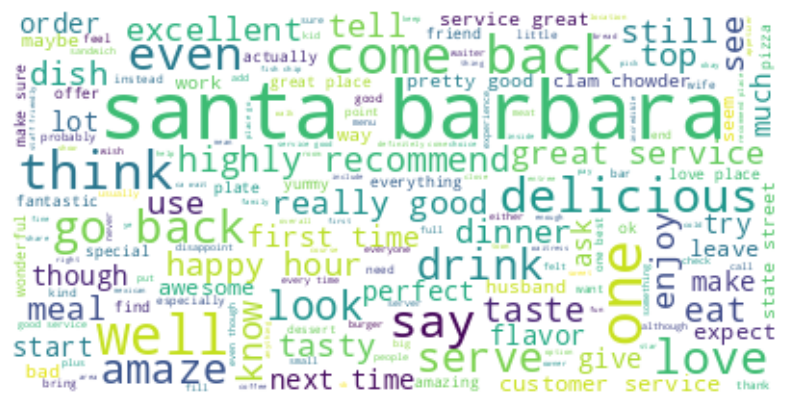

In [ ]:
# Assuming LA_star1_reviews_df.processed_text contains your preprocessed text
text = " ".join(review for review in reviews_df.processed_lemma_text)

# Define additional stopwords
additional_stopwords = {'santa barbara', 'restaurant','food'}

# Combine default stopwords with your additional stopwords
stopwords = set(STOPWORDS).union(additional_stopwords)

# Generate a word cloud image, excluding the additional stopwords
wordcloud = WordCloud(background_color='white', stopwords=stopwords).generate(text)

# Display the generated word cloud:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis grid
plt.show()

#### Overall n-grams

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


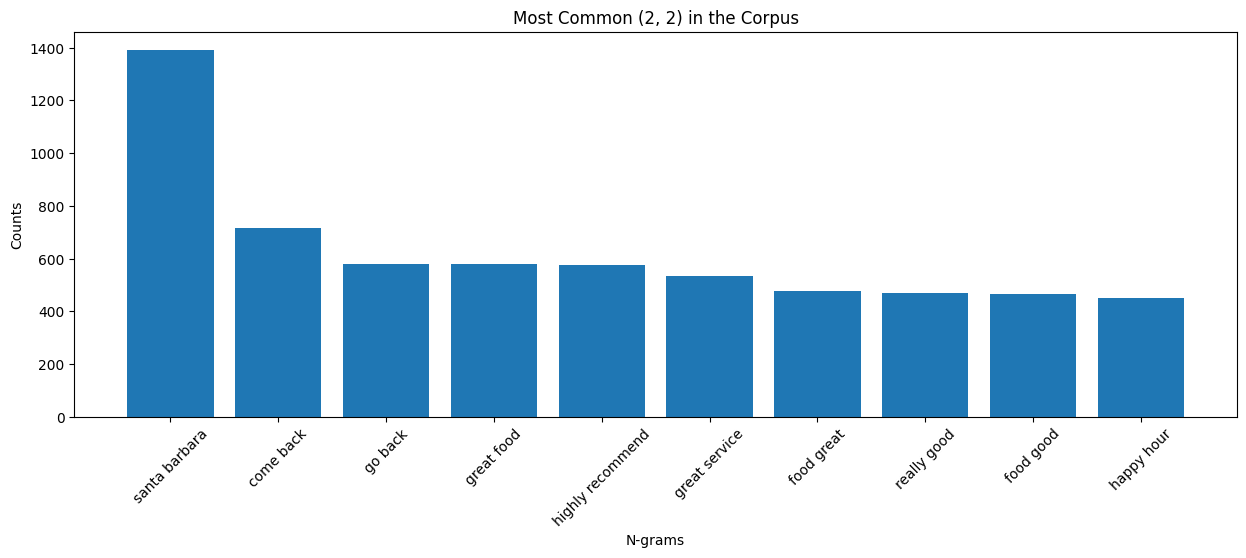

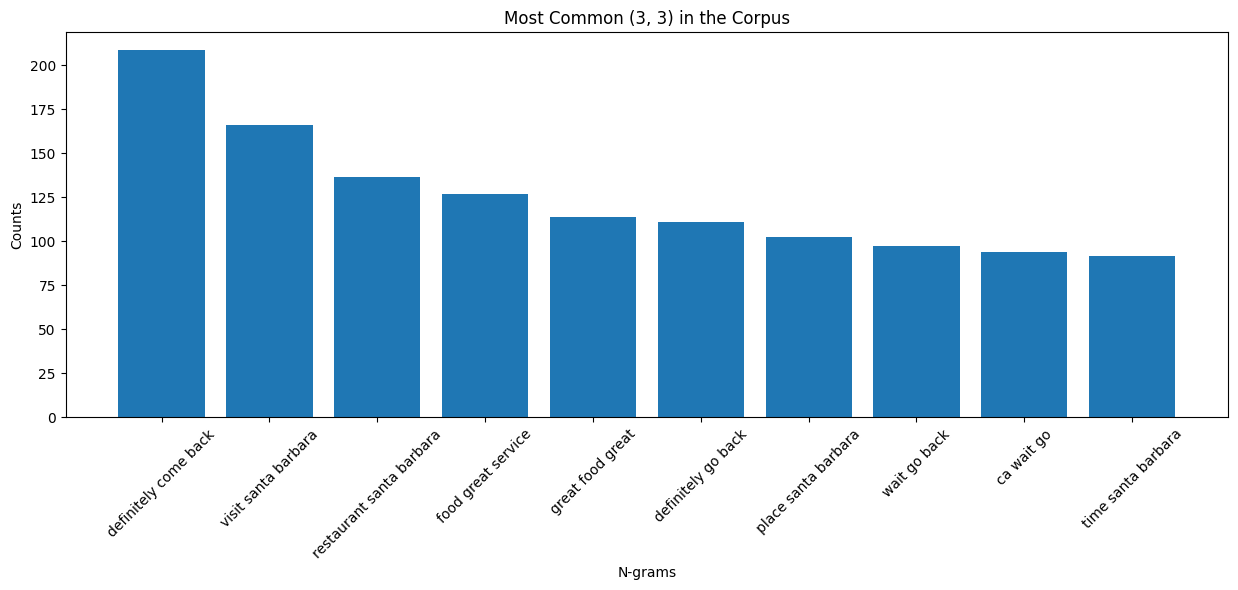

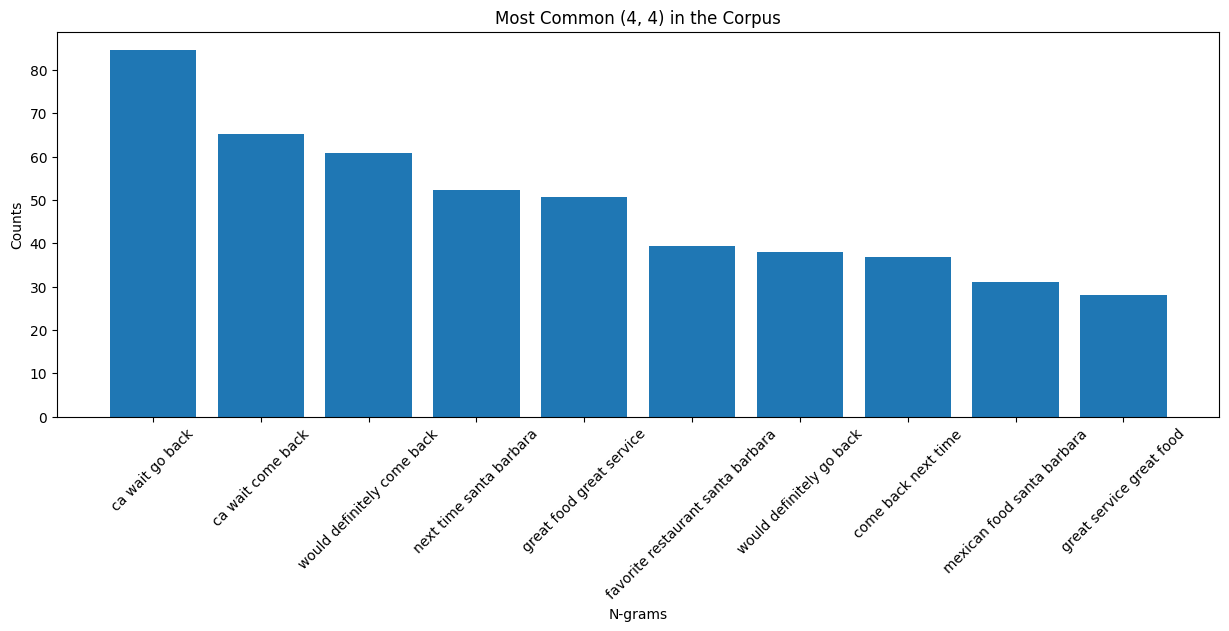

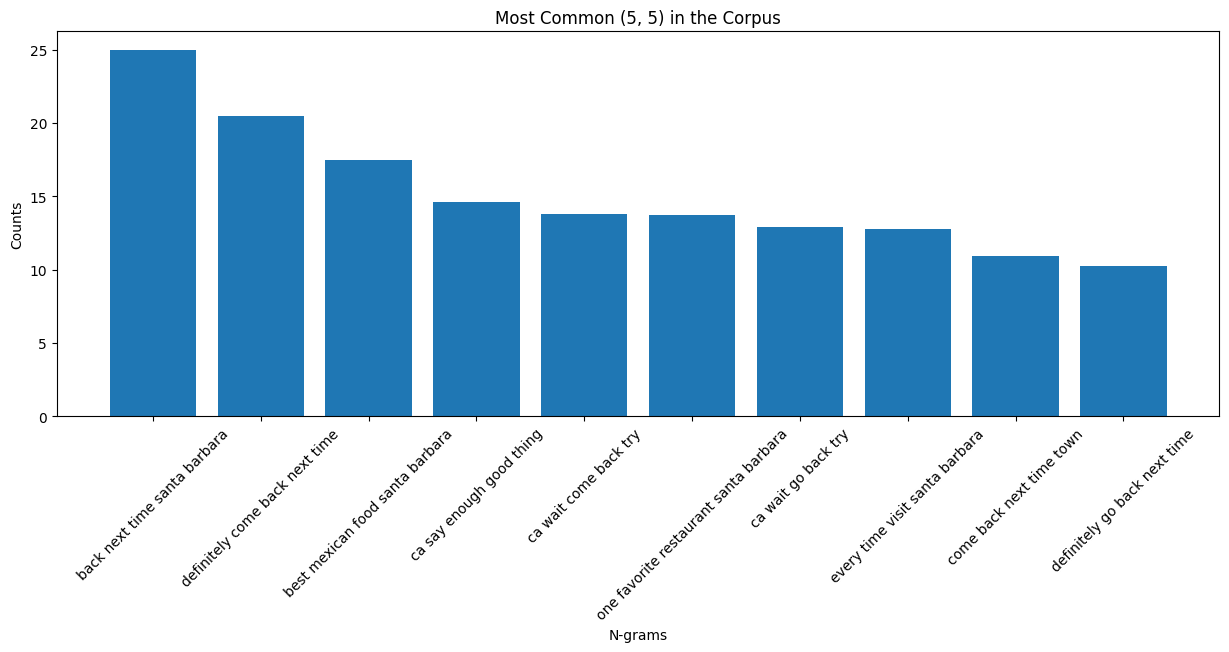

In [ ]:
def identity_tokenizer(text):
    return text

def plot_most_common_ngrams(corpus, ngram_range, top_n=10):
    vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, ngram_range=ngram_range)
    X = vectorizer.fit_transform(corpus)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]

    # Plotting
    ngrams, counts = zip(*words_freq)
    plt.figure(figsize=(15, 5))
    plt.bar(ngrams, counts)
    plt.xlabel('N-grams')
    plt.ylabel('Counts')
    plt.title(f'Most Common {ngram_range} in the Corpus')
    plt.xticks(rotation=45)
    plt.show()

# Use the 'cleaned_text_tokens' column as it contains pre-tokenized text
plot_most_common_ngrams(reviews_df.clean_lemma_text_tokens, ngram_range=(2, 2))
plot_most_common_ngrams(reviews_df.clean_lemma_text_tokens, ngram_range=(3, 3))
plot_most_common_ngrams(reviews_df.clean_lemma_text_tokens, ngram_range=(4, 4))
plot_most_common_ngrams(reviews_df.clean_lemma_text_tokens, ngram_range=(5, 5))

#### Topic Modeling

In [ ]:
num_processors = multiprocessing.cpu_count()
num_processors

workers = num_processors-1

print(f'Using {workers} workers')

Using 1 workers


In [ ]:
%%time

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
doc_complete = reviews_df['processed_text'].tolist()
data_tokens = list(sent_to_words(doc_complete))

bigram = gensim.models.Phrases(data_tokens, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[data_tokens], threshold=1)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Create n-grams
data_words_bigrams = make_bigrams(data_tokens)
data_words_trigrams = make_trigrams(data_tokens)

# Combine tokens and n-grams
# data_tokens_cobnined = data_tokens_nostops + data_words_bigrams + data_words_trigrams
data_tokens_cobnined = data_words_trigrams

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Lemmatize text keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_tokens_cobnined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# print(*data_lemmatized[:1])

# Creating the term dictionary of our courpus, where every unique term is assigned an index.
dictionary = corpora.Dictionary(data_lemmatized)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_lemmatized]

lda_model = LdaMulticore(corpus=doc_term_matrix,
                   id2word=dictionary,
                   num_topics=10,
                   random_state=100,
                   passes=10,
                   eta='auto',
                   workers=workers)

lda_model.print_topics()

CPU times: user 21.3 s, sys: 256 ms, total: 21.6 s
Wall time: 21.7 s


In [ ]:
%%time
#### Remove Stopwords, Make n-grams and Lemmatize

# bigram = gensim.models.Phrases(data_tokens, min_count=5, threshold=100)
# trigram = gensim.models.Phrases(bigram[data_tokens], threshold=100)

bigram = gensim.models.Phrases(data_tokens, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[data_tokens], threshold=1)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

CPU times: user 46.3 s, sys: 665 ms, total: 47 s
Wall time: 47.2 s


In [ ]:
%%time
# stop_words = stopwords.words('english')
# Define functions for stopwords, bigrams, trigrams and lemmatization
# def remove_stopwords(texts):
#     return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.63 µs


In [ ]:
%%time

# Remove Stop Words
# data_tokens_nostops = remove_stopwords(data_tokens)

# Create n-grams
data_words_bigrams = make_bigrams(data_tokens)
data_words_trigrams = make_trigrams(data_tokens)

# Combine tokens and n-grams
# data_tokens_cobnined = data_tokens_nostops + data_words_bigrams + data_words_trigrams
data_tokens_cobnined = data_words_trigrams

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Lemmatize text keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_tokens_cobnined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(*data_lemmatized[:1])

['think', 'already_reviewe', 'los_agave', 'twice', 'initially_came', 'tremendous_review', 'yelp', 'thanks_yelp', 'los_agave', 'mexican_restaurant', 'located_heart_santa_barbara', 'bit', 'competition', 'similar_type', 'street', 'appear', 'really', 'rise', 'los_agave', 'tell_something', 'number', 'car_parke', 'outside', 'get', 'draw', 'people_ordering', 'remember', 'order_counter', 'first', 'sit_bre', 'serve', 'mocajete', 'people', 'come_boile', 'lava_rock', 'pot', 'food_serve', 'corn_tortilla', 'come', 'meal', 'careful', 'white', 'clothing', 'get', 'stain', 'bubble', 'happen', 'choose_several', 'different_type', 'meat', 'enjoy', 'looking_somethe', 'little_le', 'messy', 'taco_burrito', 'great_choice', 'try', 'appetizer', 'quesadilla_zucchini', 'flower', 'amazing', 'tasty', 'cheese', 'put', 'thick', 'actually', 'fry', 'tortilla', 'fold', 'give', 'great', 'taste_texture', 'always_get', 'nicely_cooke', 'flavor_great', 'salsa', 'get', 'salsa_bar', 'quick', 'large_portion', 'probably', 'littl

In [ ]:
%%time

# Creating the term dictionary of our courpus, where every unique term is assigned an index.
dictionary = corpora.Dictionary(data_lemmatized)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_lemmatized]

CPU times: user 9.32 s, sys: 200 ms, total: 9.52 s
Wall time: 9.57 s


In [ ]:
%%time

lda_model = LdaMulticore(corpus=doc_term_matrix,
                   id2word=dictionary,
                   num_topics=3,
                   random_state=100,
                   passes=10,
                   eta='auto',
                   workers=workers)

CPU times: user 12min 5s, sys: 26.7 s, total: 12min 32s
Wall time: 14min 36s


In [ ]:
# Print the Keyword in the 3 topics
lda_model.print_topics()
doc_lda = lda_model[doc_term_matrix]

In [ ]:
lda_model.print_topics()

[(0,
  '0.013*"great" + 0.010*"good" + 0.009*"amazing" + 0.009*"love" + 0.008*"place" + 0.008*"food" + 0.004*"go" + 0.004*"restaurant" + 0.004*"delicious" + 0.004*"also"'),
 (1,
  '0.011*"good" + 0.009*"get" + 0.008*"order" + 0.008*"food" + 0.007*"place" + 0.006*"come" + 0.005*"eat" + 0.004*"taste" + 0.004*"go" + 0.004*"flavor"'),
 (2,
  '0.008*"get" + 0.008*"food" + 0.007*"go" + 0.006*"order" + 0.006*"say" + 0.006*"place" + 0.006*"time" + 0.005*"restaurant" + 0.005*"tell" + 0.005*"ask"')]

In [ ]:
%%time

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5837294311125518
CPU times: user 12.5 s, sys: 101 ms, total: 12.6 s
Wall time: 18 s


#### Category Analysis

In [ ]:
business_cats = ', '.join(reviews_df['categories'].astype('str'))
cats=pd.DataFrame(business_cats.split(', '),columns=['categories'])
x=cats.categories.value_counts()
x=x.sort_values(ascending=False)
x = x.iloc[1:22]
x

Nightlife                    57926
Bars                         55505
Food                         53231
American (New)               46860
Breakfast & Brunch           39280
Seafood                      37310
Mexican                      27940
American (Traditional)       26521
Cocktail Bars                20350
Sandwiches                   19825
Salad                        15653
Italian                      15445
Event Planning & Services    15126
Coffee & Tea                 14642
Burgers                      13178
Wine Bars                    12552
Cafes                        11633
Beer                         11239
Wine & Spirits               11239
Bakeries                     10351
Pizza                        10213
Name: categories, dtype: int64

In [ ]:
keyword = "Breakfast & Brunch"  # Replace with your keyword
reviews_df_breakfast_brunch = reviews_df[reviews_df['categories'].apply(lambda x: keyword in x)][['categories','processed_lemma_text']]
reviews_df_breakfast_brunch

,categories,processed_lemma_text
5,"French, Cafes, Restaurants, Breakfast & Brunch, Food, Sandwiches, Bakeries",first stop pastry bread crawl town great begin croissant perfect bake dark flaky buttery doughy bready also get chocolate macaron fan macarons good one finally peanut butter cookie enjoy great work
6,"Food, Restaurants, Salad, Coffee & Tea, Breakfast & Brunch, Sandwiches, Bakeries",time get belly pretty stuff order two cooky chai snickerdoodle peanut butter brittle simply delicious snickerdoodle thick puffy soft fill warm spice chai tea meanwhile pb cookie rich peanut buttery flavor sticky hard crunch include bit peanut brittle sit outside lovely patio wish room eat
7,"Restaurants, Cafes, Breakfast & Brunch, Bakeries, Food",already get full stop pastry eat order much friend love little olive roll choose medium size hunk ciabatta soft squishy like like friend kid split chocolate brioche torpedo really dry flavorless chocolate make palatable
8,"Specialty Food, Health Markets, Restaurants, Gluten-Free, Bakeries, Coffee & Tea, Desserts, Breakfast & Brunch, Food",bias gf pastry execute well good sometimes even well depend make wheat flour sadly case buy banana walnut muffin triple chocolate cookie muffin decent texture good banana flavor strong chocolate cookie major disappointment insanely hard crispy little flavor beautiful space plenty seat bright warm atmosphere wo rush return
13,"Tapas/Small Plates, Desserts, Restaurants, Breakfast & Brunch, Food, Seafood",love fishouse covid ton outdoor seat reinstate happy hour great food great drink great service say hi friend gm chris best
...,...,...
162264,"American (New), Restaurants, Breakfast & Brunch",grow day tutti rule coast village road montecito old mom discover tutti little sister cafe tuttini could happier table inside outside gem place die tuttini divine minestrone chop salad fan fritatta pastry bread drink great menu consist mostly sandwich soup salad cuisine well service iffy time employee turn quickly hole wall state street draw local foreigner tourist alike downtown area want breakfast lunch snack beware hour pm
162265,"American (New), Restaurants, Breakfast & Brunch",ca believe one write sourdough belgian waffle tuttini tutti crispy outside fluffy inside unique mellow sourdough flavor come slice fresh strawberry real maple syrup yum make back sb twice year day always get waffle ala last trip sb august waffle maker break come way hawaii waffle disappointment chocolate peanut butter banana panini instead good nothing compare magical waffle little sister agree assessment
162266,"Bakeries, Food, Restaurants, Coffee & Tea, Cafes, Breakfast & Brunch",go many bakery area decide henning wed cake professional fairest price willing work around idea wed even taste cake neither husband care sweet asuri cake fabulous make decision go bakery easy even go pick fresh flower cake decoration happy go henning big day
162267,"Bakeries, Food, Restaurants, Coffee & Tea, Cafes, Breakfast & Brunch",go hennings recommendation coworker birthday cake boyfriend last week work one manager regret get card name fabulous work craft perfect cake even stop twice change little drawing staff nothing helpful end result beautiful get white cake butter cream frosting whip cream fresh strawberry fill perfect combination everyone love go special occasion


In [ ]:
# Keyword to search for
keyword = 'Nightlife'

# Search across the DataFrame for the keyword
reviews_df_night_life = reviews_df[reviews_df['categories'].apply(lambda x: keyword in x)][['categories','processed_lemma_text']]
reviews_df_night_life

,categories,processed_lemma_text
3,"Cocktail Bars, Fish & Chips, Nightlife, Seafood, Restaurants, Bars",place go celebration good food impeccable service gorgeous waitress hope girlfriend read amazing food
11,"Seafood, American (New), Sandwiches, Steakhouses, Restaurants, Bars, Nightlife",filet mignon sooooo good
12,"Seafood, American (New), Sandwiches, Steakhouses, Restaurants, Bars, Nightlife",martini filet mignon crave place go friendly staff great drink excellent food never disappoint feel like meat risotto best town asparagus artichoke walnut truffle oil delicious
21,"Venues & Event Spaces, Cafes, Wine Bars, Event Planning & Services, Nightlife, Bars, Restaurants, American (New)",decide give wine cask try santa barbara restaurant week gem hidden inside el paseo get appetizer entree dessert do restaurant week usually portion taste meal treat serve fresh bread delightful herbed butter portion good size potato leek soup hubby crudo soup flavorful silky enjoyable hubby crudo tasty eye soup whole time second course share gnocchi pork shank flavorful inventive dessert opt berry tart creme brulee prefer tart brulee miso surprising saltiness great meal exceptional service al...
22,"Nightlife, American (Traditional), Cafes, Restaurants, Wine Bars, Breakfast & Brunch, Bars",cody great outdoors space make sure check breakfast favorite love corn beef hash egg benedict huevos rancheros reasonably price great service
...,...,...
162039,"Sports Bars, Bars, Barbeque, Nightlife, Restaurants",new location nice food service suck never go back use love old location state street even return customer sad get new owner salad cheap ice berg lettuce three dry piece bbq could make good home save money also take minute get food place dead know take staff long anyway would recommend place anybody miss old killer also small
162040,"Sports Bars, Bars, Barbeque, Nightlife, Restaurants",food new location take significant dive quality brisket plate brisket sandwich love brisket know suppose fatty brisket almost fat bad quality ever server could care le service either love food service old location must make terrible decision move new location
162041,"Sports Bars, Bars, Barbeque, Nightlife, Restaurants",come santa barbara day trip look good bbq family wow one waitress slllllllooooowwwww service hot sauce burnt onion ring cesar salad taste rib return place
162042,"Sports Bars, Bars, Barbeque, Nightlife, Restaurants",try first time tonight great price good food tasty


##### Sentiment Analysis

In [ ]:
import tweepy
import pytz

In [ ]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.9 MB/s eta 0:00:00


In [ ]:
tweepy.__version__

'4.14.0'

In [ ]:
#Load the SentimentIntensityAnalyzer object from the VADER package
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Create a handle to the SentimentIntensityAnalyzer object
analyzer = SentimentIntensityAnalyzer()

In [ ]:
##apply on processed_lemma_text
business_id = []
review_id = []
user_id = []
name_x = []
categories = []
date = []
stars_x = []
stars_y = []
processed_lemma_text = []
review_sentiment_score = []

# Iterate over each row in the DataFrame
for index, row in reviews_df.iterrows():
    business_id.append(row['business_id'])
    review_id.append(row['review_id'])
    user_id.append(row['user_id'])
    name_x.append(row['name_x'])
    categories.append(row['categories'])
    date.append(row['date'])
    stars_x.append(row['stars_x'])
    stars_y.append(row['stars_y'])
    processed_lemma_text.append(row['processed_lemma_text'])

    review_sentiment_score.append(analyzer.polarity_scores(row['processed_lemma_text'])["compound"])

# Create a DataFrame from the collected data
sentiment_df = pd.DataFrame({
    'business_id': business_id,
    'review_id': review_id,
    'user_id': user_id,
    'name_x': name_x,
    'categories': categories,
    'date': date,
    'stars_x': stars_x,
    'stars_y': stars_y,
    'processed_lemma_text': processed_lemma_text,
    'sentiment_score': review_sentiment_score
})

# Clean up 'processed_lemma_text' column by replacing '\n' with space
sentiment_df['processed_lemma_text'] = sentiment_df['processed_lemma_text'].str.replace('\n', ' ', regex=False)

# Create a sentiment label based on sentiment score
sentiment_df['sentiment'] = pd.cut(sentiment_df['sentiment_score'].astype(float),
                                   bins=[-1, 0, 1],
                                   labels=['Negative', 'Positive'],
                                   right=False)

# Adjust to include 'Neutral' sentiment for a score of exactly 0
sentiment_df['sentiment'] = sentiment_df.apply(
    lambda x: 'Neutral' if x['sentiment_score'] == 0 else x['sentiment'], axis=1)

In [ ]:
## apply on just text
business_id = []
review_id = []
user_id = []
name_x = []
categories = []
date = []
stars_x = []
stars_y = []
text = []
review_sentiment_score = []

# Iterate over each row in the DataFrame
for index, row in reviews_df.iterrows():
    business_id.append(row['business_id'])
    review_id.append(row['review_id'])
    user_id.append(row['user_id'])
    name_x.append(row['name_x'])
    categories.append(row['categories'])
    date.append(row['date'])
    stars_x.append(row['stars_x'])
    stars_y.append(row['stars_y'])
    text.append(row['text'])

    review_sentiment_score.append(analyzer.polarity_scores(row['text'])["compound"])

# Create a DataFrame from the collected data
sentiment_text_df = pd.DataFrame({
    'business_id': business_id,
    'review_id': review_id,
    'user_id': user_id,
    'name_x': name_x,
    'categories': categories,
    'date': date,
    'stars_x': stars_x,
    'stars_y': stars_y,
    'text': text,
    'sentiment_score': review_sentiment_score
})

# Clean up 'text' column by replacing '\n' with space
sentiment_text_df['text'] = sentiment_text_df['text'].str.replace('\n', ' ', regex=False)

# Create a sentiment label based on sentiment score
sentiment_text_df['sentiment'] = pd.cut(sentiment_text_df['sentiment_score'].astype(float),
                                   bins=[-1, 0, 1],
                                   labels=['Negative', 'Positive'],
                                   right=False)

# Adjust to include 'Neutral' sentiment for a score of exactly 0
sentiment_text_df['sentiment'] = sentiment_text_df.apply(
    lambda x: 'Neutral' if x['sentiment_score'] == 0 else x['sentiment'], axis=1)

correlation between stars and sentiment_score

In [ ]:
star_sentiment = sentiment_df[['stars_x','stars_y','sentiment_score','sentiment']]

,stars_x,stars_y,sentiment_score,sentiment
0,4.5,4.0,0.9900,Positive
1,4.5,5.0,0.8176,Positive
2,4.5,5.0,0.0000,Neutral
3,4.0,5.0,0.9274,Positive
4,4.5,4.0,0.9325,Positive
...,...,...,...,...
162278,3.0,5.0,0.9686,Positive
162279,3.0,5.0,0.6369,Positive
162280,3.5,2.0,0.1531,Positive
162281,3.5,5.0,0.7506,Positive


In [ ]:
sentiment_df.sentiment.value_counts()

Positive    150083
Negative     11098
Neutral       1102
Name: sentiment, dtype: int64

In [ ]:
sentiment_df.stars_y.value_counts()

5.0    82511
4.0    36109
3.0    16448
1.0    15104
2.0    12111
Name: stars_y, dtype: int64

In [ ]:
sentiment_df.stars_x.value_counts()

4.0    73441
4.5    45324
3.5    30634
3.0     7025
2.5     3120
5.0     1989
2.0      587
1.5      163
Name: stars_x, dtype: int64

In [ ]:
sentiment_df[['stars_x','stars_y','sentiment_score']]

,stars_x,stars_y,sentiment_score
0,4.5,4.0,0.9900
1,4.5,5.0,0.8176
2,4.5,5.0,0.0000
3,4.0,5.0,0.9274
4,4.5,4.0,0.9325
...,...,...,...
162278,3.0,5.0,0.9686
162279,3.0,5.0,0.6369
162280,3.5,2.0,0.1531
162281,3.5,5.0,0.7506


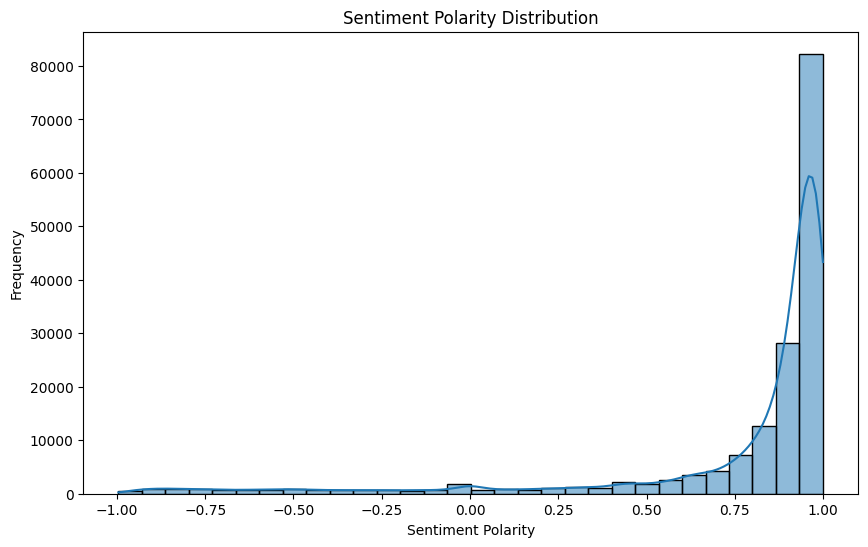

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(sentiment_df['sentiment_score'], bins=30, kde=True)
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

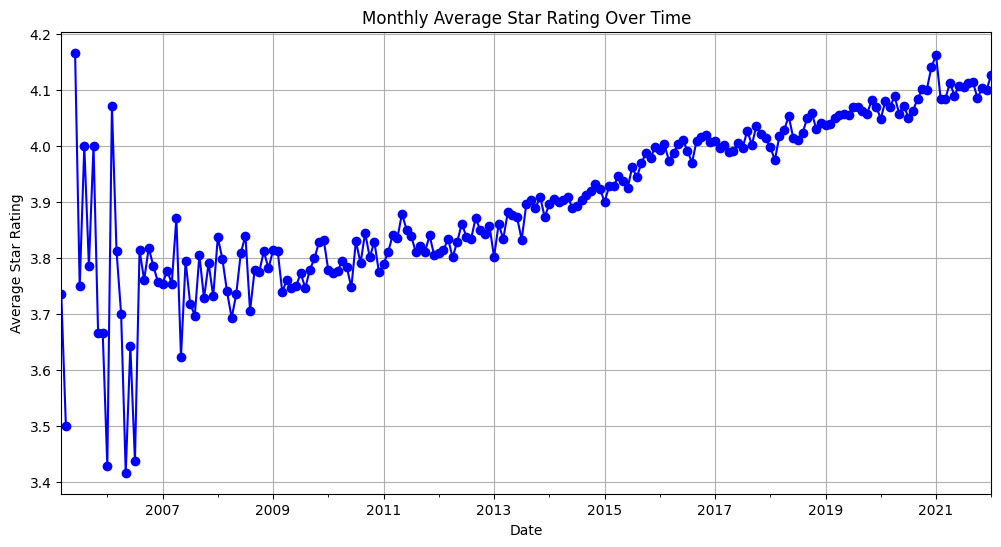

In [ ]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

# Sort the DataFrame by 'review_date'
sentiment_df = sentiment_df.sort_values('date')

# Aggregate the data by a chosen time period. Here, we calculate the monthly average star rating.
# Change 'M' to another frequency ('W' for weekly, 'D' for daily, etc.) as needed.
monthly_average_stars = sentiment_df.resample('M', on='date')['stars_x'].mean()

# Plotting
plt.figure(figsize=(12, 6))
monthly_average_stars.plot(kind='line', marker='o', color='blue')
plt.title('Monthly Average Star Rating Over Time')
plt.xlabel('Date')
plt.ylabel('Average Star Rating')
plt.grid(True)
plt.show()

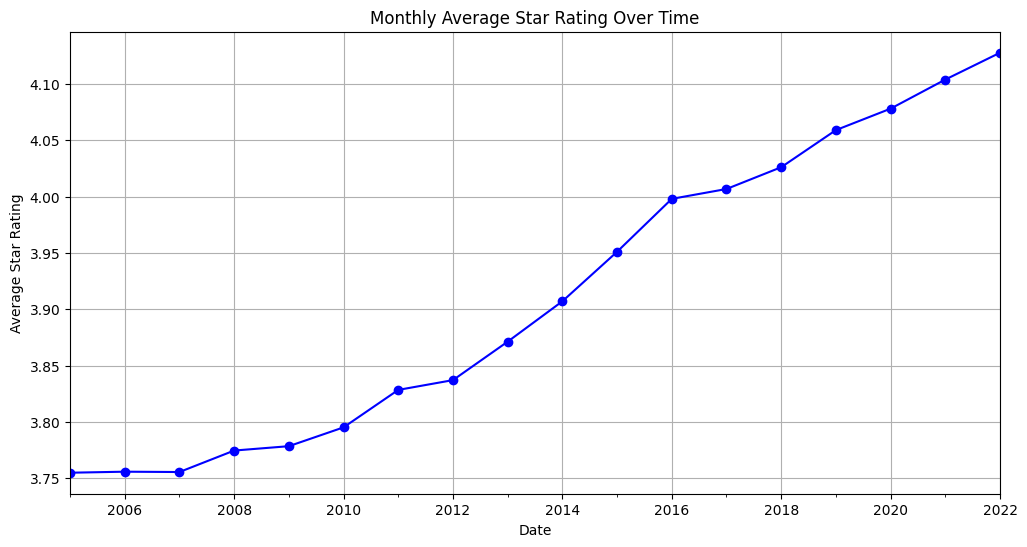

In [ ]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

# Sort the DataFrame by 'review_date'
sentiment_df = sentiment_df.sort_values('date')

# Aggregate the data by a chosen time period. Here, we calculate the monthly average star rating.
# Change 'M' to another frequency ('W' for weekly, 'D' for daily, etc.) as needed.
monthly_average_stars = sentiment_df.resample('Y', on='date')['stars_x'].mean()

# Plotting
plt.figure(figsize=(12, 6))
monthly_average_stars.plot(kind='line', marker='o', color='blue')
plt.title('Monthly Average Star Rating Over Time')
plt.xlabel('Date')
plt.ylabel('Average Star Rating')
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

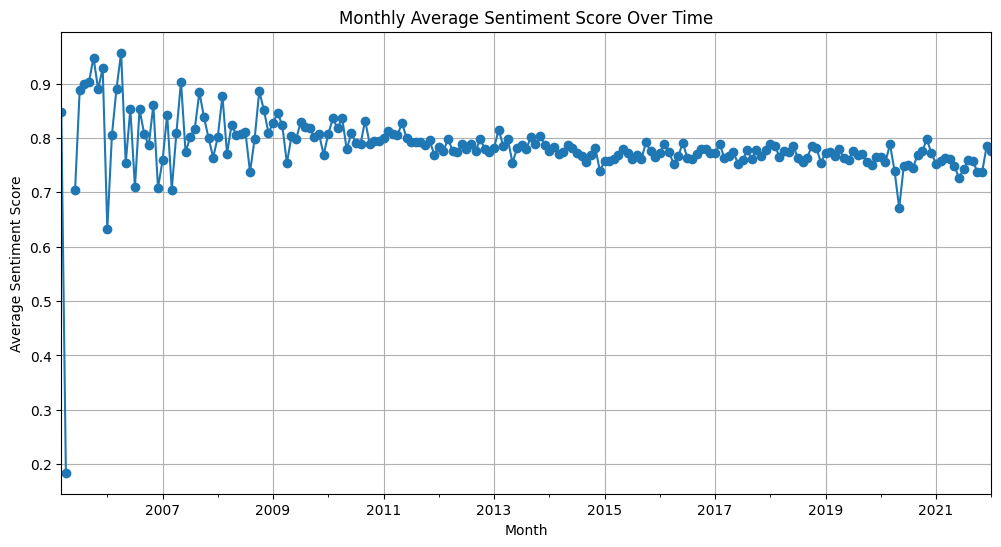

In [ ]:
review_time_df = sentiment_df.copy()

review_time_df['date'] = pd.to_datetime(review_time_df['date'])

# Sort the DataFrame by 'review_date'
review_time_df = review_time_df.sort_values('date')

# Aggregate the data by a chosen time period, here we use monthly average sentiment score
# You can change 'M' to 'W' for weekly, 'D' for daily, etc., as needed
monthly_sentiment = review_time_df.resample('M', on='date')['sentiment_score'].mean()

# Plotting
plt.figure(figsize=(12, 6))
monthly_sentiment.plot(kind='line', marker='o')
plt.title('Monthly Average Sentiment Score Over Time')
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.show()

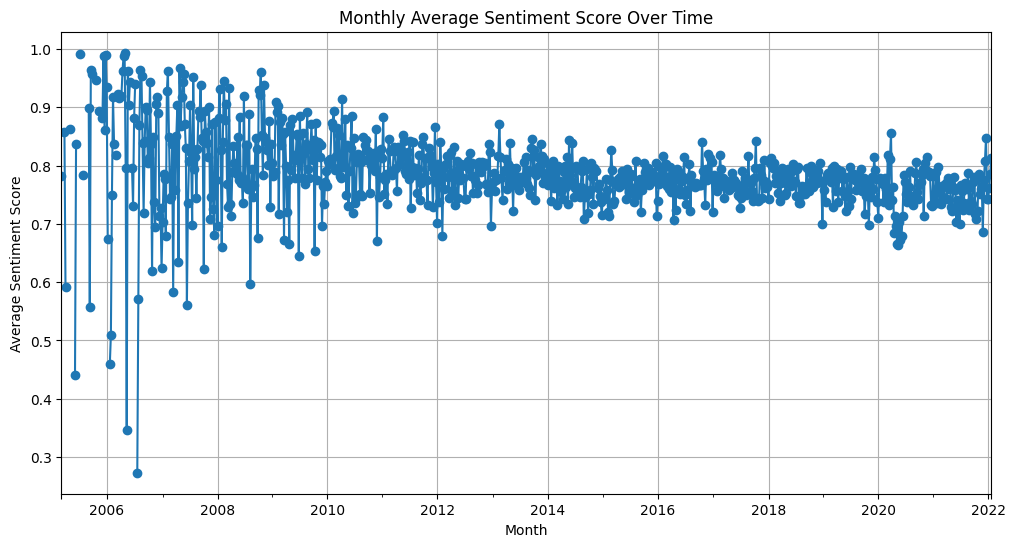

In [ ]:
review_time_df = sentiment_df.copy()

review_time_df['date'] = pd.to_datetime(review_time_df['date'])

# Sort the DataFrame by 'review_date'
review_time_df = review_time_df.sort_values('date')

# Aggregate the data by a chosen time period, here we use monthly average sentiment score
# You can change 'M' to 'W' for weekly, 'D' for daily, etc., as needed
monthly_sentiment = review_time_df.resample('W', on='date')['sentiment_score'].mean()

# Plotting
plt.figure(figsize=(12, 6))
monthly_sentiment.plot(kind='line', marker='o')
plt.title('Monthly Average Sentiment Score Over Time')
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.show()

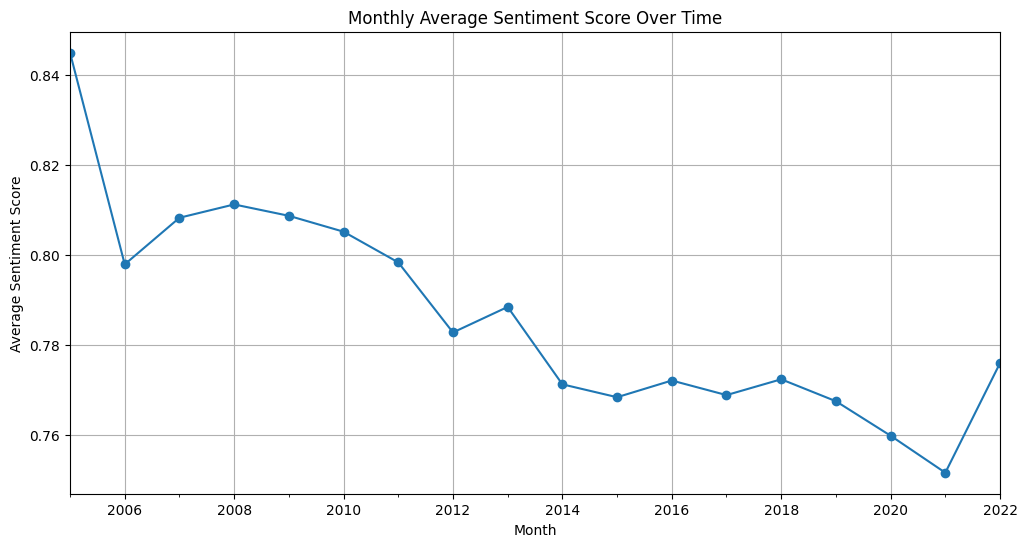

In [ ]:
review_time_df = sentiment_df.copy()

review_time_df['date'] = pd.to_datetime(review_time_df['date'])

# Sort the DataFrame by 'review_date'
review_time_df = review_time_df.sort_values('date')

# Aggregate the data by a chosen time period, here we use monthly average sentiment score
# You can change 'M' to 'W' for weekly, 'D' for daily, etc., as needed
monthly_sentiment = review_time_df.resample('Y', on='date')['sentiment_score'].mean()

# Plotting
plt.figure(figsize=(12, 6))
monthly_sentiment.plot(kind='line', marker='o')
plt.title('Monthly Average Sentiment Score Over Time')
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.show()

In [ ]:
sentiment_df['stars_x'] = pd.to_numeric(sentiment_df['stars_x'], errors='coerce')
sentiment_df['sentiment_score'] = pd.to_numeric(sentiment_df['sentiment_score'], errors='coerce')

correlation_coefficient = sentiment_df['stars_x'].corr(sentiment_df['sentiment_score'])

print(f"Correlation Coefficient between Star Ratings and Sentiment Score: {correlation_coefficient}")

Correlation Coefficient between Star Ratings and Sentiment Score: 0.20563264074116896


In [ ]:
analysis_df = sentiment_df.copy()
analysis_df['stars_y'] = pd.to_numeric(analysis_df['stars_y'], errors='coerce')
analysis_df['sentiment_score'] = pd.to_numeric(analysis_df['sentiment_score'], errors='coerce')

correlation_coefficient = analysis_df['stars_y'].corr(analysis_df['sentiment_score'])

print(f"Correlation Coefficient between Star Ratings and Sentiment Score: {correlation_coefficient}")

Correlation Coefficient between Star Ratings and Sentiment Score: 0.5447964630360616


In [ ]:
from scipy.stats import chi2_contingency
import numpy as np

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Calculate Cramér's V for sentiment_category vs. stars_y
cramers_v_value = cramers_v(sentiment_df['sentiment'], sentiment_df['stars_y'])
print(f"Cramér's V: {cramers_v_value}")


Cramér's V: 0.35922187197321004


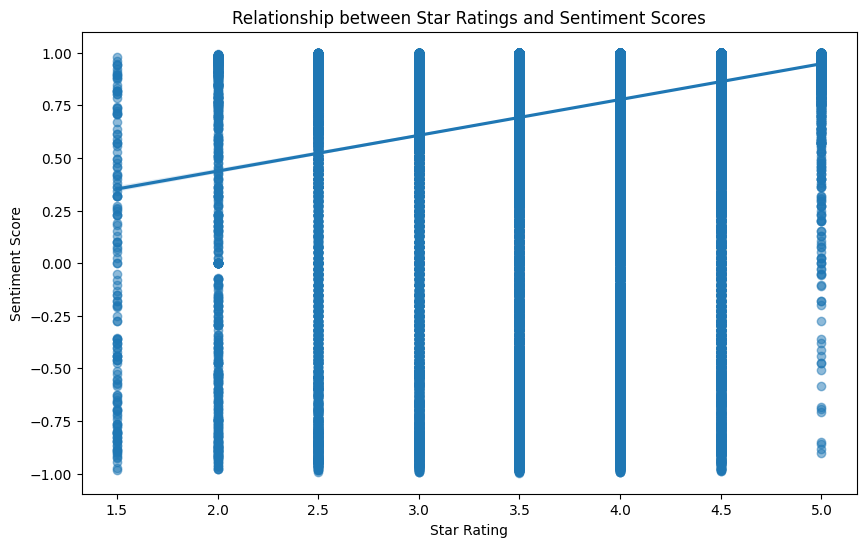

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Create a scatter plot with a regression line to visualize the relationship
sns.regplot(x='stars_x', y='sentiment_score', data=sentiment_df, scatter_kws={'alpha':0.5})

plt.title('Relationship between Star Ratings and Sentiment Scores')
plt.xlabel('Star Rating')
plt.ylabel('Sentiment Score')
plt.show()

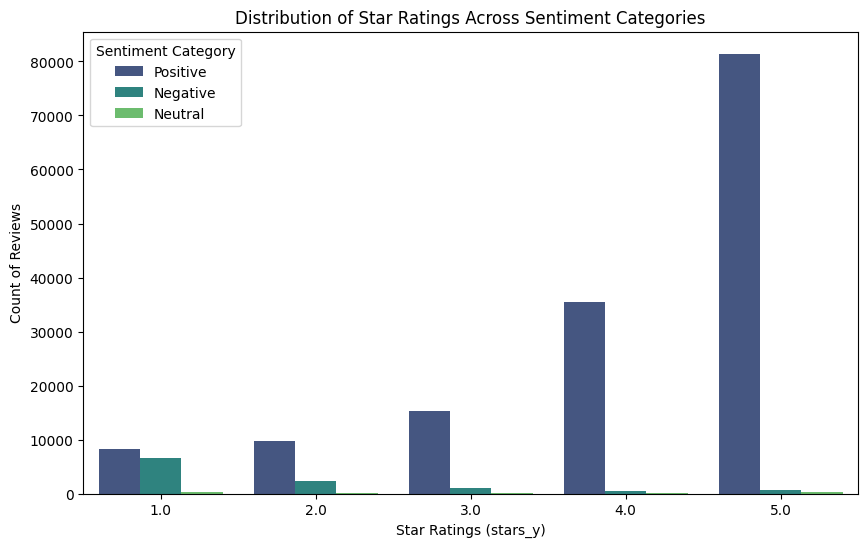

In [ ]:
plt.figure(figsize=(10, 6))

sns.countplot(x='stars_y', hue='sentiment', data=sentiment_df, palette='viridis')

plt.title('Distribution of Star Ratings Across Sentiment Categories')
plt.xlabel('Star Ratings (stars_y)')
plt.ylabel('Count of Reviews')
plt.legend(title='Sentiment Category')
plt.show()

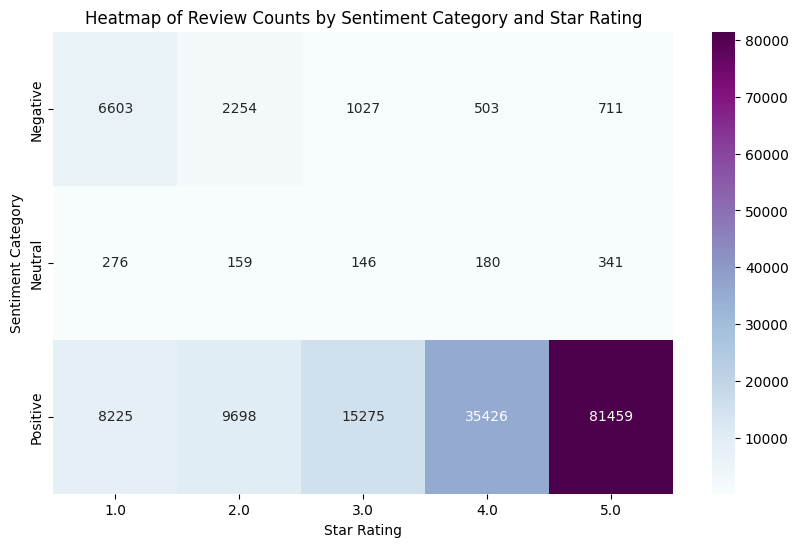

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Creating a cross-tabulation of sentiment categories and star ratings
ct = pd.crosstab(sentiment_df['sentiment'], sentiment_df['stars_y'])

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(ct, annot=True, fmt="d", cmap="BuPu", cbar=True)
plt.title('Heatmap of Review Counts by Sentiment Category and Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Sentiment Category')
plt.show()

SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# # Assuming X and y are your features and target variable respectively
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# sm = SMOTE(random_state=42)
# X_res, y_res = sm.fit_resample(X_train, y_train)

##### reviews_df_breakfast_brunch

In [ ]:
keyword = "Breakfast & Brunch"

sentiment_df_breakfast_brunch = sentiment_df[sentiment_df['categories'].apply(lambda x: keyword in x)]

In [ ]:
sentiment_df_breakfast_brunch.sentiment.value_counts()

Positive    36448
Negative     2547
Neutral       285
Name: sentiment, dtype: int64

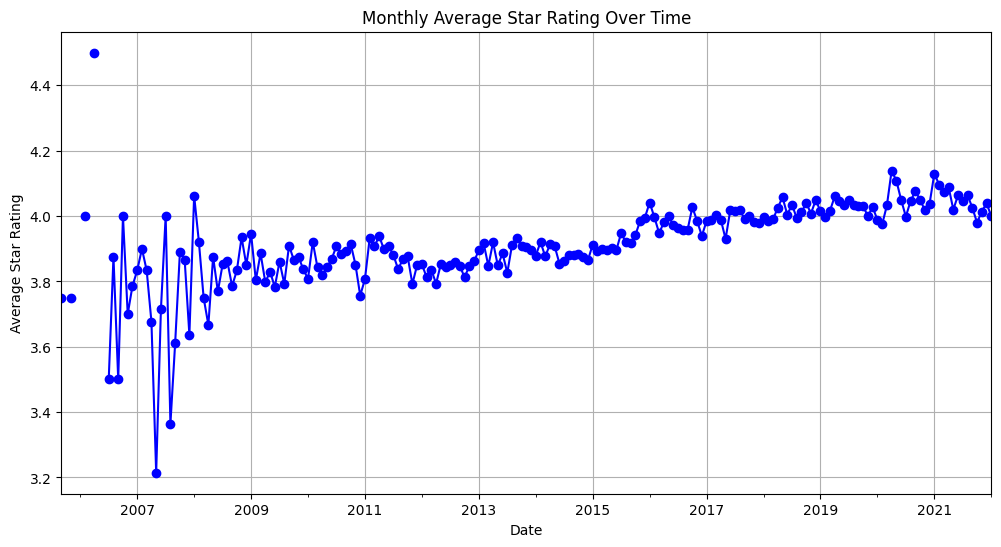

In [ ]:
sentiment_df_breakfast_brunch['date'] = pd.to_datetime(sentiment_df_breakfast_brunch['date'])

# Sort the DataFrame by 'review_date'
sentiment_df_breakfast_brunch = sentiment_df_breakfast_brunch.sort_values('date')

# Aggregate the data by a chosen time period. Here, we calculate the monthly average star rating.
# Change 'M' to another frequency ('W' for weekly, 'D' for daily, etc.) as needed.
monthly_average_stars = sentiment_df_breakfast_brunch.resample('M', on='date')['stars_x'].mean()

# Plotting
plt.figure(figsize=(12, 6))
monthly_average_stars.plot(kind='line', marker='o', color='blue')
plt.title('Monthly Average Star Rating Over Time')
plt.xlabel('Date')
plt.ylabel('Average Star Rating')
plt.grid(True)
plt.show()

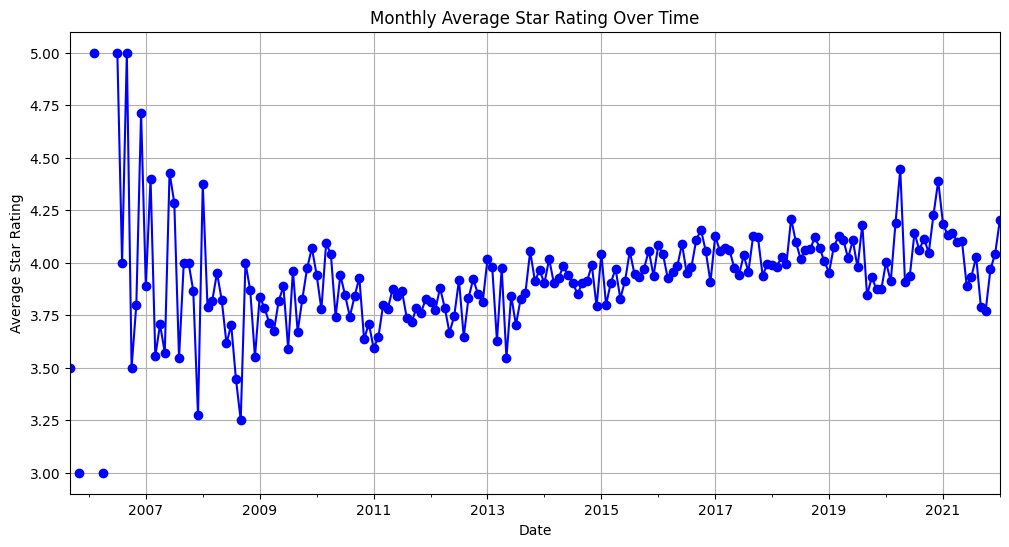

In [ ]:
sentiment_df_breakfast_brunch['date'] = pd.to_datetime(sentiment_df_breakfast_brunch['date'])

# Sort the DataFrame by 'review_date'
sentiment_df_breakfast_brunch = sentiment_df_breakfast_brunch.sort_values('date')

# Aggregate the data by a chosen time period. Here, we calculate the monthly average star rating.
# Change 'M' to another frequency ('W' for weekly, 'D' for daily, etc.) as needed.
monthly_average_stars = sentiment_df_breakfast_brunch.resample('M', on='date')['stars_y'].mean()

# Plotting
plt.figure(figsize=(12, 6))
monthly_average_stars.plot(kind='line', marker='o', color='blue')
plt.title('Monthly Average Star Rating Over Time')
plt.xlabel('Date')
plt.ylabel('Average Star Rating')
plt.grid(True)
plt.show()

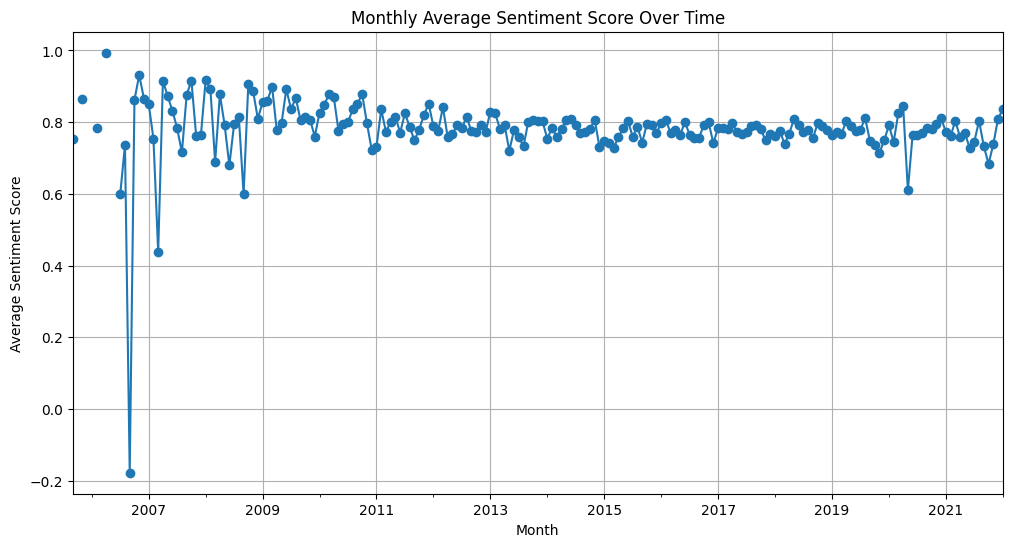

In [ ]:
review_time_df = sentiment_df_breakfast_brunch.copy()

review_time_df['date'] = pd.to_datetime(review_time_df['date'])

# Sort the DataFrame by 'review_date'
review_time_df = review_time_df.sort_values('date')

# Aggregate the data by a chosen time period, here we use monthly average sentiment score
# You can change 'M' to 'W' for weekly, 'D' for daily, etc., as needed
monthly_sentiment = review_time_df.resample('M', on='date')['sentiment_score'].mean()

# Plotting
plt.figure(figsize=(12, 6))
monthly_sentiment.plot(kind='line', marker='o')
plt.title('Monthly Average Sentiment Score Over Time')
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.show()

###### reviews_df_night_life

In [ ]:
keyword = "Nightlife"

sentiment_df_nightlife = sentiment_df[sentiment_df['categories'].apply(lambda x: keyword in x)]

In [ ]:
sentiment_df_nightlife.sentiment.value_counts()

Positive    54231
Negative     3392
Neutral       303
Name: sentiment, dtype: int64

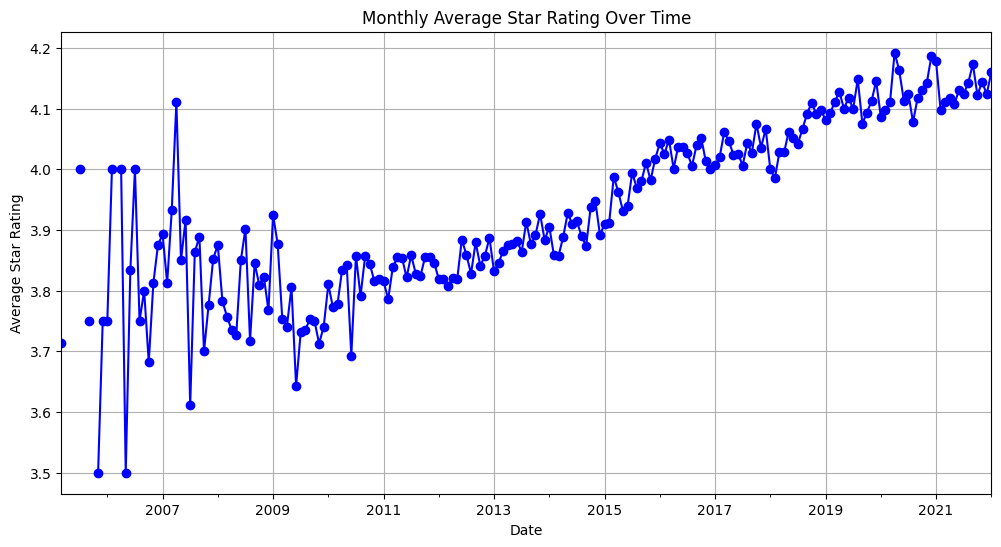

In [ ]:
sentiment_df_nightlife['date'] = pd.to_datetime(sentiment_df_nightlife['date'])

# Sort the DataFrame by 'review_date'
sentiment_df_nightlife = sentiment_df_nightlife.sort_values('date')

# Aggregate the data by a chosen time period. Here, we calculate the monthly average star rating.
# Change 'M' to another frequency ('W' for weekly, 'D' for daily, etc.) as needed.
monthly_average_stars = sentiment_df_nightlife.resample('M', on='date')['stars_x'].mean()

# Plotting
plt.figure(figsize=(12, 6))
monthly_average_stars.plot(kind='line', marker='o', color='blue')
plt.title('Monthly Average Star Rating Over Time')
plt.xlabel('Date')
plt.ylabel('Average Star Rating')
plt.grid(True)
plt.show()

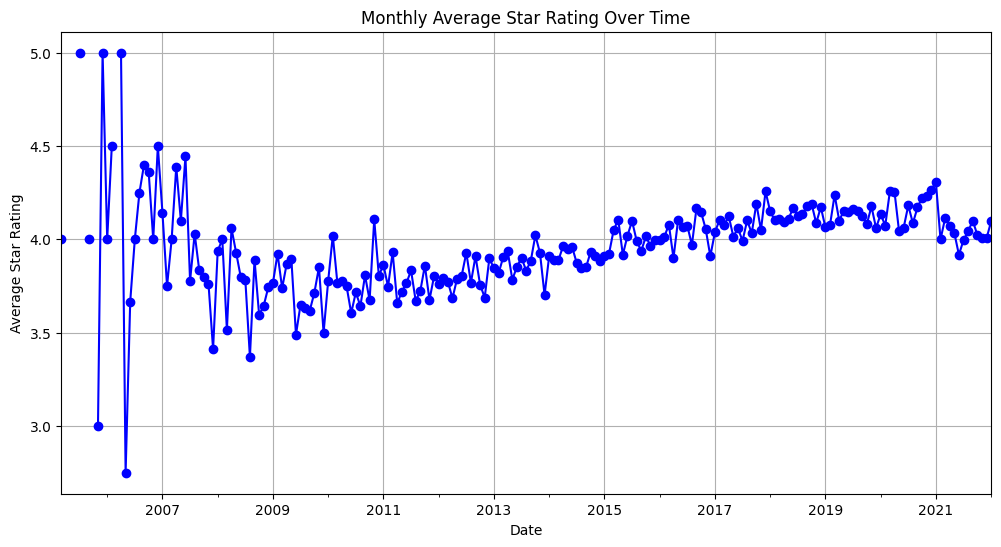

In [ ]:
sentiment_df_nightlife['date'] = pd.to_datetime(sentiment_df_nightlife['date'])

# Sort the DataFrame by 'review_date'
sentiment_df_nightlife = sentiment_df_nightlife.sort_values('date')

# Aggregate the data by a chosen time period. Here, we calculate the monthly average star rating.
# Change 'M' to another frequency ('W' for weekly, 'D' for daily, etc.) as needed.
monthly_average_stars = sentiment_df_nightlife.resample('M', on='date')['stars_y'].mean()

# Plotting
plt.figure(figsize=(12, 6))
monthly_average_stars.plot(kind='line', marker='o', color='blue')
plt.title('Monthly Average Star Rating Over Time')
plt.xlabel('Date')
plt.ylabel('Average Star Rating')
plt.grid(True)
plt.show()

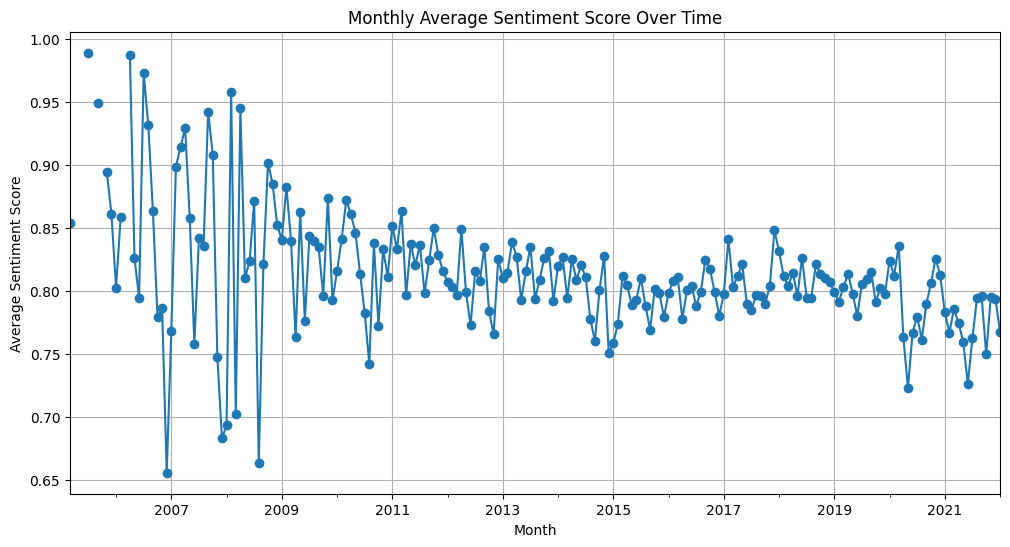

In [ ]:
review_time_df = sentiment_df_nightlife.copy()

review_time_df['date'] = pd.to_datetime(review_time_df['date'])

# Sort the DataFrame by 'review_date'
review_time_df = review_time_df.sort_values('date')

# Aggregate the data by a chosen time period, here we use monthly average sentiment score
# You can change 'M' to 'W' for weekly, 'D' for daily, etc., as needed
monthly_sentiment = review_time_df.resample('M', on='date')['sentiment_score'].mean()

# Plotting
plt.figure(figsize=(12, 6))
monthly_sentiment.plot(kind='line', marker='o')
plt.title('Monthly Average Sentiment Score Over Time')
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.show()

##### Topic Modeling


In [ ]:
%%time

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
doc_complete = reviews_df_breakfast_brunch['processed_lemma_text'].tolist()
data_tokens = list(sent_to_words(doc_complete))

bigram = gensim.models.Phrases(data_tokens, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[data_tokens], threshold=1)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Create n-grams
data_words_bigrams = make_bigrams(data_tokens)
data_words_trigrams = make_trigrams(data_tokens)

# Combine tokens and n-grams
# data_tokens_cobnined = data_tokens_nostops + data_words_bigrams + data_words_trigrams
data_tokens_cobnined = data_words_trigrams

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Lemmatize text keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_tokens_cobnined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# print(*data_lemmatized[:1])

# Creating the term dictionary of our courpus, where every unique term is assigned an index.
dictionary = corpora.Dictionary(data_lemmatized)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_lemmatized]

lda_model = LdaMulticore(corpus=doc_term_matrix,
                   id2word=dictionary,
                   num_topics=10,
                   random_state=100,
                   passes=10,
                   eta='auto',
                   workers=workers)

lda_model.print_topics()

CPU times: user 6min 45s, sys: 10.2 s, total: 6min 56s
Wall time: 7min 40s


[(0,
  '0.020*"bowl" + 0.019*"sandwich" + 0.011*"salad" + 0.009*"lunch" + 0.008*"acai_bowl" + 0.007*"cheese" + 0.005*"backyard_bowl" + 0.005*"healthy" + 0.004*"love" + 0.004*"good"'),
 (1,
  '0.010*"gluten_free" + 0.008*"ihop" + 0.004*"service_awesome" + 0.003*"great_price" + 0.003*"service_prompt" + 0.002*"bake_good" + 0.002*"quiche" + 0.002*"everything_fresh" + 0.002*"healthy_delicious" + 0.002*"shop_cafe"'),
 (2,
  '0.012*"order" + 0.012*"food" + 0.011*"get" + 0.010*"go" + 0.009*"place" + 0.008*"come" + 0.008*"say" + 0.007*"restaurant" + 0.007*"time" + 0.006*"service"'),
 (3,
  '0.018*"great" + 0.016*"good" + 0.014*"place" + 0.012*"love" + 0.011*"food" + 0.009*"great_food" + 0.008*"amaze" + 0.008*"service" + 0.007*"breakfast" + 0.007*"highly_recommend"'),
 (4,
  '0.012*"great_coffee" + 0.008*"reasonable_price" + 0.007*"place_amaze" + 0.006*"quick_service" + 0.006*"good_coffee" + 0.005*"best_breakfast" + 0.005*"definitely_come_back" + 0.005*"great_staff" + 0.004*"amaze_food" + 0.004*

In [ ]:
%%time

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
doc_complete = reviews_df_night_life['processed_lemma_text'].tolist()
data_tokens = list(sent_to_words(doc_complete))

bigram = gensim.models.Phrases(data_tokens, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[data_tokens], threshold=1)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Create n-grams
data_words_bigrams = make_bigrams(data_tokens)
data_words_trigrams = make_trigrams(data_tokens)

# Combine tokens and n-grams
# data_tokens_cobnined = data_tokens_nostops + data_words_bigrams + data_words_trigrams
data_tokens_cobnined = data_words_trigrams

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Lemmatize text keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_tokens_cobnined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# print(*data_lemmatized[:1])

# Creating the term dictionary of our courpus, where every unique term is assigned an index.
dictionary = corpora.Dictionary(data_lemmatized)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_lemmatized]

In [ ]:
lda_model = LdaMulticore(corpus=doc_term_matrix,
                   id2word=dictionary,
                   num_topics=10,
                   random_state=100,
                   passes=10,
                   eta='auto',
                   workers=workers)

lda_model.print_topics()

[(0,
  '0.018*"good" + 0.010*"get" + 0.009*"order" + 0.008*"come" + 0.007*"flavor" + 0.007*"sauce" + 0.007*"great" + 0.006*"burger" + 0.006*"dish" + 0.006*"salad"'),
 (1,
  '0.008*"great_food_great_service" + 0.005*"great_ambience" + 0.003*"friendly_staff" + 0.003*"bake_good" + 0.003*"lobster_ravioli" + 0.003*"great_environment" + 0.002*"bring_friend" + 0.002*"staff_awesome" + 0.002*"extremely_rude" + 0.002*"little_gem"'),
 (2,
  '0.003*"mollie" + 0.003*"service_exceptional" + 0.003*"triple_play" + 0.003*"good_well" + 0.003*"recommend_anyone" + 0.003*"pleasant_experience" + 0.002*"everyone_work" + 0.002*"food_spectacular" + 0.002*"nice_location" + 0.002*"whole_family"'),
 (3,
  '0.005*"place" + 0.003*"food" + 0.002*"horrible_service" + 0.002*"eureka" + 0.002*"go" + 0.002*"never_return" + 0.002*"venue" + 0.002*"bar" + 0.002*"come_across" + 0.002*"band"'),
 (4,
  '0.007*"food_incredible" + 0.006*"beer_good" + 0.005*"start_finish" + 0.004*"must_stop" + 0.004*"next_time_sb" + 0.003*"defini

#### Restaurant Analysis

In [ ]:
# Filter reviews with 5 stars and count them per business_id
most5StarsReviews = reviews_df[reviews_df['stars_y'] == 5].groupby('name_x').size().reset_index(name='Count')
most5StarsReviews = most5StarsReviews.sort_values(by='Count', ascending=False).head(10)
most5StarsReviews

,name_x,Count
335,Los Agaves,3214
377,Mesa Verde,1523
85,Brophy Bros - Santa Barbara,1355
70,Boathouse at Hendry's Beach,1274
523,Santa Barbara Shellfish Company,1022
345,Lure Fish House,980
75,Bouchon,971
456,Pickles & Swiss,939
624,The Lark,891
309,La Super-Rica Taqueria,869


##### Most 5 stars restaurant: Los Agaves

In [ ]:
LA_reviews_df = reviews_df[reviews_df.name_x == 'Los Agaves']

In [ ]:
LA_reviews_df[['name_x','processed_lemma_text','clean_lemma_text_tokens','stars_y']]

,name_x,processed_lemma_text,clean_lemma_text_tokens,stars_y
0,Los Agaves,woops think already review los agave twice initially come tremendous review yelp thanks yelp los agave nice little mexican restaurant locate heart santa barbara actually quite bit competition similar type food street appear really rise top los agave look like much outside tell something number car park outside get draw long line people order remember order counter first sit bring order number serve mocajete people come boil lava rock pot food serve corn tortilla come meal careful white cloth...,"[woops, think, already, review, los, agave, twice, initially, come, tremendous, review, yelp, thanks, yelp, los, agave, nice, little, mexican, restaurant, locate, heart, santa, barbara, actually, quite, bit, competition, similar, type, food, street, appear, really, rise, top, los, agave, look, like, much, outside, tell, something, number, car, park, outside, get, draw, long, line, people, order, remember, order, counter, first, sit, bring, order, number, serve, mocajete, people, come, boil, ...",4.0
1,Los Agaves,drive coast stop drive santa barbara saw popular ordered appetizer dinner amongst two wish enough room stomach finish best mexican food id ever,"[drive, coast, stop, drive, santa, barbara, saw, popular, ordered, appetizer, dinner, amongst, two, wish, enough, room, stomach, finish, best, mexican, food, id, ever]",5.0
2,Los Agaves,really look review place place end mexican food joint santa barbara wantgood mexican food go,"[really, look, review, place, place, end, mexican, food, joint, santa, barbara, wantgood, mexican, food, go]",5.0
4,Los Agaves,full disclosure walk go la taqueria turn close january consider intended meal mood mexican expect letdown fortunately happen survey broad menu consult cashier decide split two item agave enchilada seafood burrito dorado chicken burrito dorado around delicious burrito flavorful filing downside cheese inside clearly melted place seem slam last night forgive little bit downer agave enchilada rocked exception fact deliver maybe ten minute burrito everything perfect chipotle cream sauce top gooey...,"[full, disclosure, walk, go, la, taqueria, turn, close, january, consider, intended, meal, mood, mexican, expect, letdown, fortunately, happen, survey, broad, menu, consult, cashier, decide, split, two, item, agave, enchilada, seafood, burrito, dorado, chicken, burrito, dorado, around, delicious, burrito, flavorful, filing, downside, cheese, inside, clearly, melted, place, seem, slam, last, night, forgive, little, bit, downer, agave, enchilada, rocked, exception, fact, deliver, maybe, ten, m...",4.0
9,Los Agaves,come los agave since almost day one restaurant keep expand evolve one thing stay really good fresh food owner carlos restaurant brother man helm favorite enchilada guadalajara great green sauce come rice bean pasilla chile campestre chilie stuff choice meat cheese cilantro cream sauce top two fresh corn tortilla also mocajetes albondingas soup posole always fresh delicious,"[come, los, agave, since, almost, day, one, restaurant, keep, expand, evolve, one, thing, stay, really, good, fresh, food, owner, carlos, restaurant, brother, man, helm, favorite, enchilada, guadalajara, great, green, sauce, come, rice, bean, pasilla, chile, campestre, chilie, stuff, choice, meat, cheese, cilantro, cream, sauce, top, two, fresh, corn, tortilla, also, mocajetes, albondingas, soup, posole, always, fresh, delicious]",4.0
...,...,...,...,...
124398,Los Agaves,pretty dissatisfied come expect great meal get chicken enchilada rojas agave enchilada guacamole guacamole come second chip salsa small portion dollar taste disgust flavor seem old end leave half food arrive excited love seafood enchilada well best thing sauce shrimp mushy undercooked could taste salad nasty orange cranberry lettuce sweet dressing end leave well grandmother chicken enchilada ask want taste cut bite find piece paper like wrapper write inside enchilada ugh overal

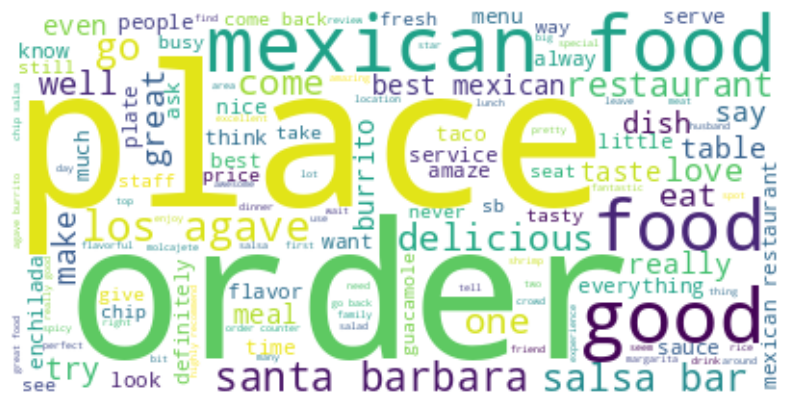

In [ ]:
# Concatenate all text from the 'text_column' into a single string
text = " ".join(review for review in LA_reviews_df.processed_lemma_text)

# Generate a word cloud image
wordcloud = WordCloud(background_color='white').generate(text)

# Display the generated word cloud:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis grid
plt.show()

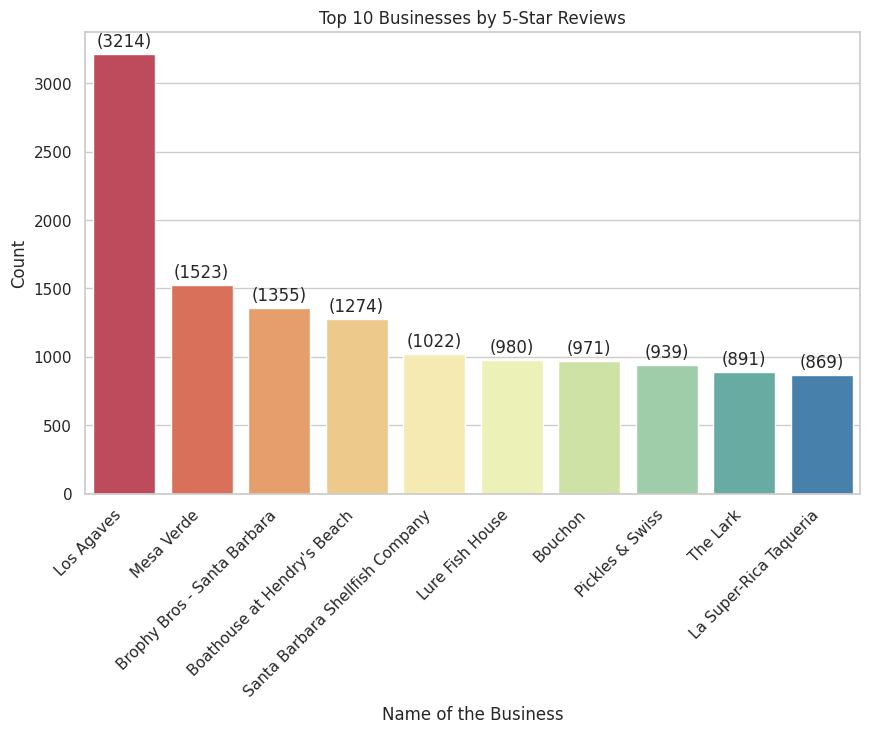

In [ ]:
# Plotting
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='name_x', y='Count', data=most5StarsReviews, palette='Spectral', edgecolor="white")
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right')
barplot.set(xlabel='Name of the Business', ylabel='Count', title='Top 10 Businesses by 5-Star Reviews')

# Add count labels to bars
for p in barplot.patches:
    barplot.annotate(f'({int(p.get_height())})',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 9),
                     textcoords='offset points')

plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


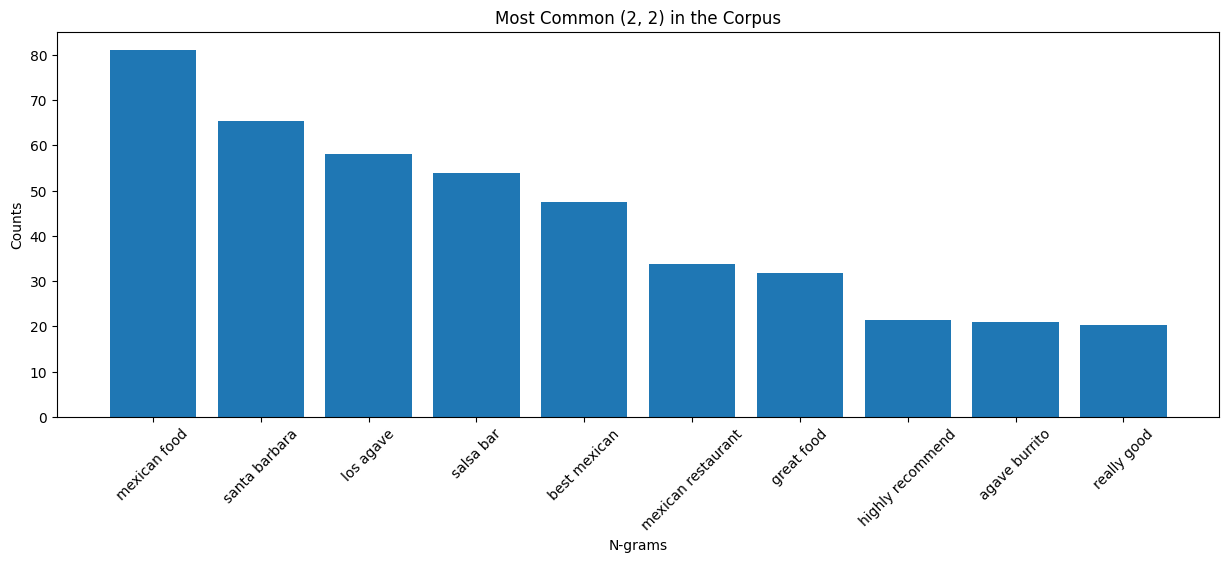

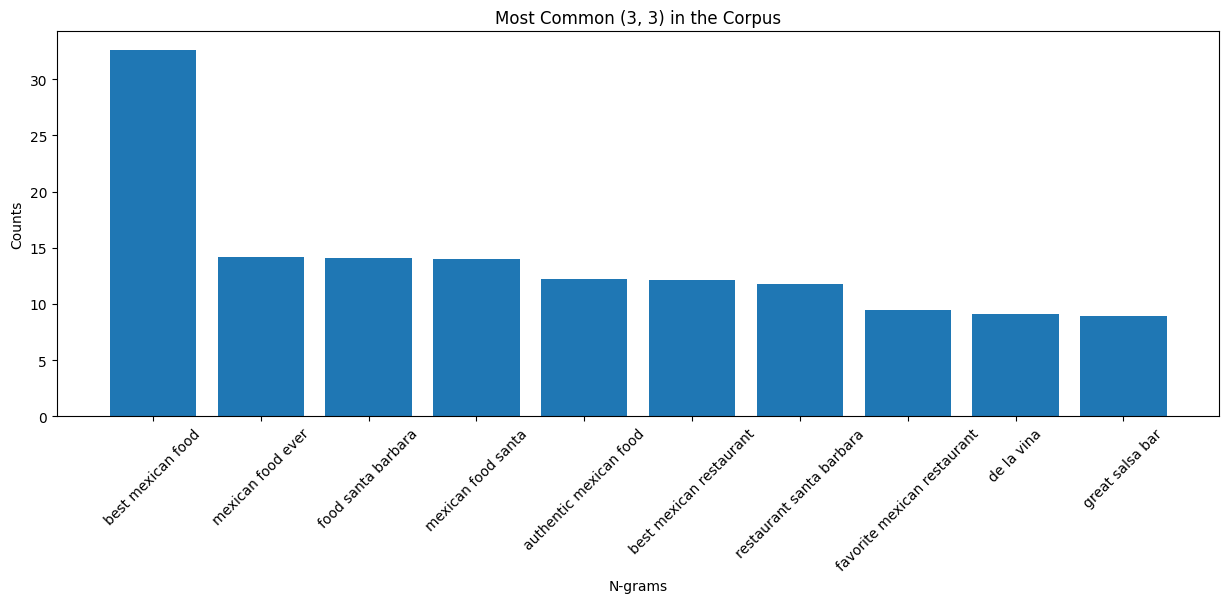

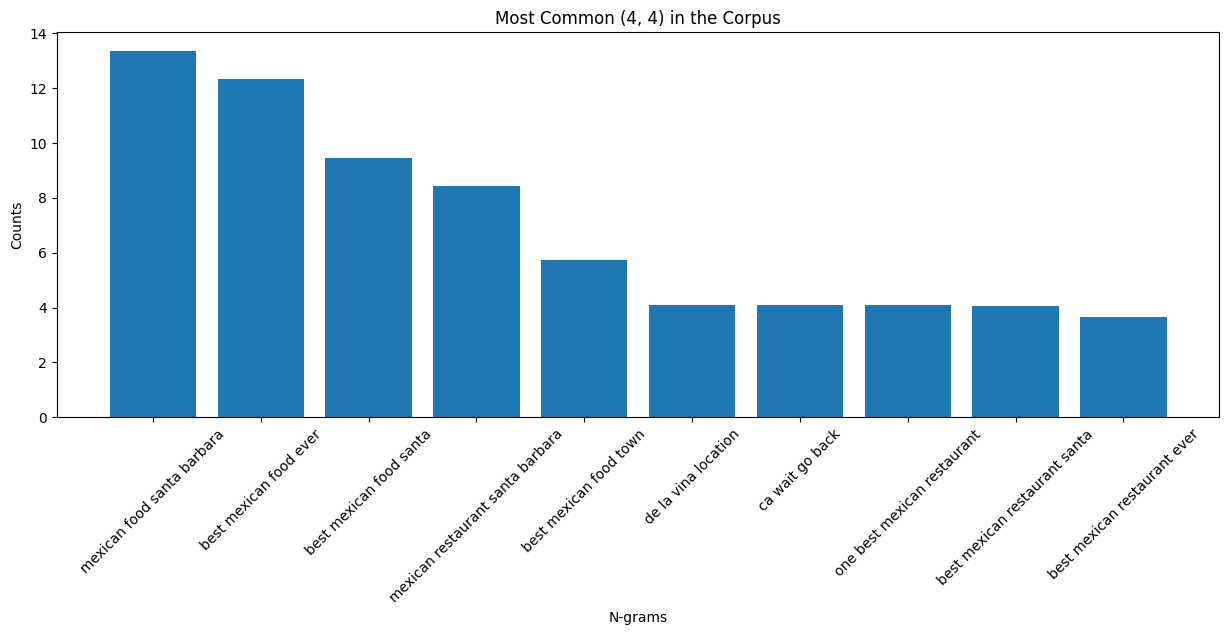

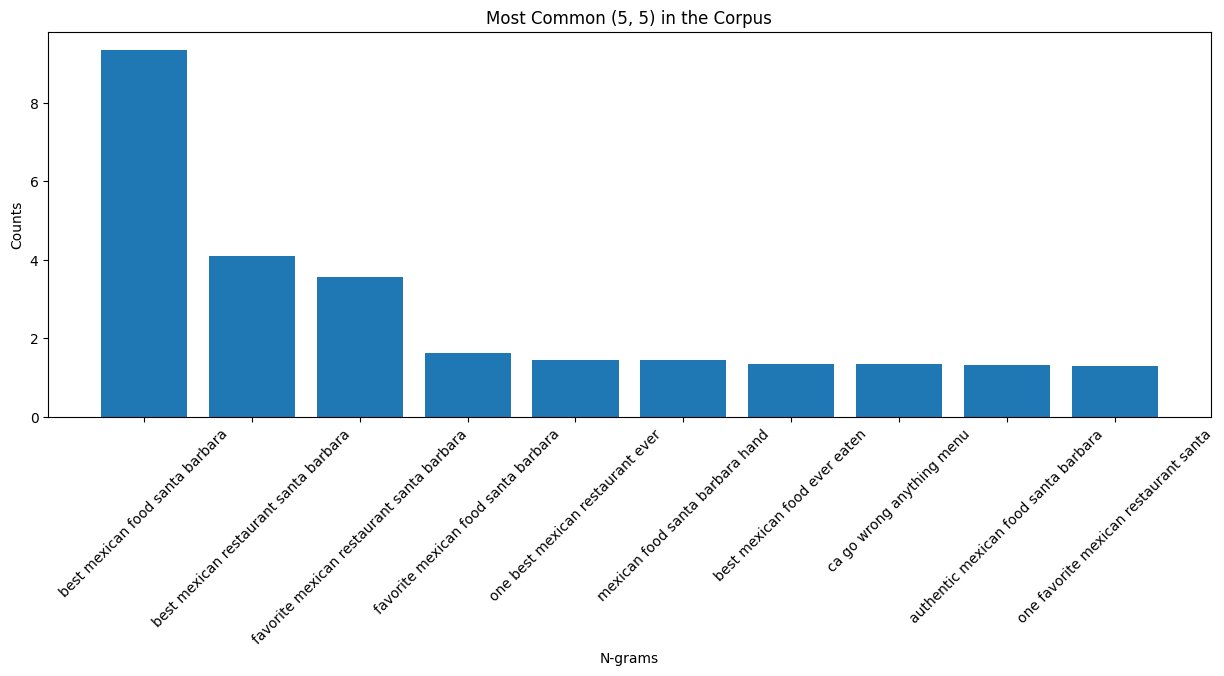

In [ ]:
def identity_tokenizer(text):
    return text

def plot_most_common_ngrams(corpus, ngram_range, top_n=10):
    vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, ngram_range=ngram_range)
    X = vectorizer.fit_transform(corpus)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]

    # Plotting
    ngrams, counts = zip(*words_freq)
    plt.figure(figsize=(15, 5))
    plt.bar(ngrams, counts)
    plt.xlabel('N-grams')
    plt.ylabel('Counts')
    plt.title(f'Most Common {ngram_range} in the Corpus')
    plt.xticks(rotation=45)
    plt.show()

# Use the 'cleaned_text_tokens' column as it contains pre-tokenized text
plot_most_common_ngrams(LA_reviews_df.clean_text_tokens, ngram_range=(2, 2))
plot_most_common_ngrams(LA_reviews_df.clean_text_tokens, ngram_range=(3, 3))
plot_most_common_ngrams(LA_reviews_df.clean_text_tokens, ngram_range=(4, 4))
plot_most_common_ngrams(LA_reviews_df.clean_text_tokens, ngram_range=(5, 5))

##### Most 1 star restaurant

In [ ]:
# Filter reviews with 5 stars and count them per business_id
most1StarsReviews = reviews_df[reviews_df['stars_y'] == 1].groupby('name_x').size().reset_index(name='Count')
most1StarsReviews = most1StarsReviews.sort_values(by='Count', ascending=False).head(10)
most1StarsReviews

,name_x,Count
320,Mar Monte Hotel - Hyatt,266
458,Sandbar,226
576,"The Ritz-Carlton Bacara, Santa Barbara",212
342,Moby Dick Restaurant,206
295,Los Agaves,198
391,Pascucci,197
59,Boathouse at Hendry's Beach,184
467,Santa Barbara Shellfish Company,183
444,Rusty's Pizza Parlor,172
72,Brophy Bros - Santa Barbara,138


In [ ]:
## sentiment
Target = ["Mar Monte Hotel - Hyatt", "Sandbar", "The Ritz-Carlton Bacara, Santa Barbara", "Moby Dick Restaurant", "Los Agaves", "Pascucci", "Boathouse at Hendry's Beach", 'Santa Barbara Shellfish Company', "Rusty's Pizza Parlor", "Brophy Bros - Santa Barbara"]
Top10_most1StarsReviews = sentiment_df[(sentiment_df['name_x'].isin(Target)) & (sentiment_df['stars_y'] == 1)]

In [ ]:
## Topic Modeling
Target = ["Mar Monte Hotel - Hyatt", "Sandbar", "The Ritz-Carlton Bacara, Santa Barbara", "Moby Dick Restaurant", "Los Agaves", "Pascucci", "Boathouse at Hendry's Beach", 'Santa Barbara Shellfish Company', "Rusty's Pizza Parlor", "Brophy Bros - Santa Barbara"]
Top10_most1StarsReviews_df = reviews_df[(reviews_df['name_x'].isin(Target)) & (sentiment_df['stars_y'] == 1)]

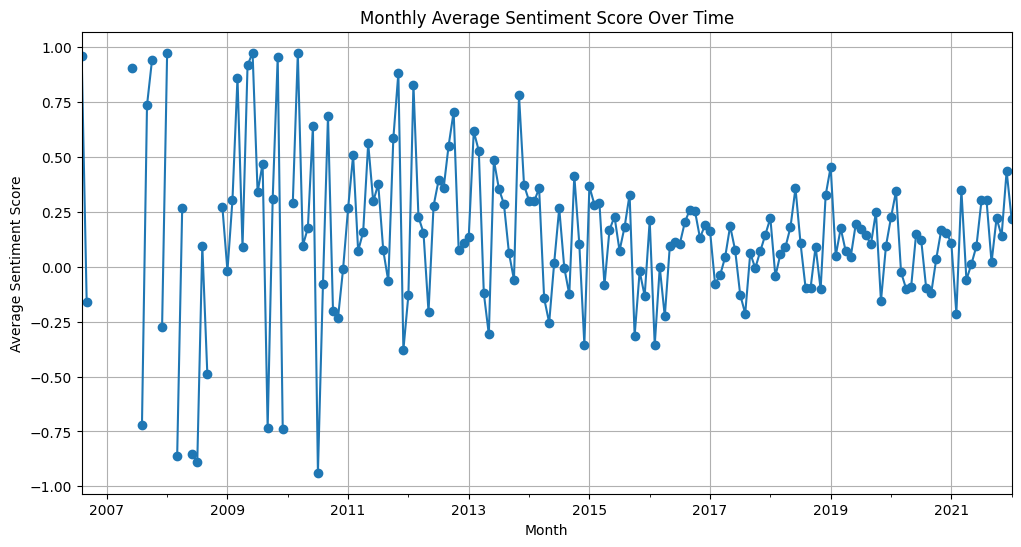

In [ ]:
review_time_df = Top10_most1StarsReviews.copy()

review_time_df['date'] = pd.to_datetime(review_time_df['date'])

# Sort the DataFrame by 'review_date'
review_time_df = review_time_df.sort_values('date')

# Aggregate the data by a chosen time period, here we use monthly average sentiment score
# You can change 'M' to 'W' for weekly, 'D' for daily, etc., as needed
monthly_sentiment = review_time_df.resample('M', on='date')['sentiment_score'].mean()

# Plotting
plt.figure(figsize=(12, 6))
monthly_sentiment.plot(kind='line', marker='o')
plt.title('Monthly Average Sentiment Score Over Time')
plt.xlabel('Month')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.show()

In [ ]:
Top10_most1StarsReviews[['name_x','processed_lemma_text']]

,name_x,processed_lemma_text
29879,"The Ritz-Carlton Bacara, Santa Barbara",go go ahead differ colleague come visit company retreat stay night room expect extremely nice ground beautiful pool great service hand worst anywhere let sum diabetic bacara bit emergency accidentally take bit much medication blood sugar take nose dive would last several hour call front desk ask pitcher orange juice number local pharmacy twenty minute later nothing arrive one call call front desk idea talk request stuff fast forward another minute call front desk time success get help kind h...
75995,Pascucci,boooooo take anything away review let boooooo impressed place italian go could barely hold name food terrible spaghetti carbonara recognize make differently silver spoon cookbook really people well soggy spaghetti night dominate though patio chair yes strange may sound decide affinnaty either pant probably content pant result decide hook belt loop let stand congratulate waitress poor service could find place get nomination bad food service long time boooooo
83946,"The Ritz-Carlton Bacara, Santa Barbara",star service high end resort slightly peeve friend mine stay anniversary arrange champagne chocolate cover strawberry deliver check cost fine well deliver present told couple hotel even put note total fuck week later find call woman elluria take care arrangement never really apologized tell hotel reimburse strawberry champagne fine tell need write apology letter couple well fail tell present really say look sure happen still wait letter friend receive explanation letter yet month disappoint ...
21708,Brophy Bros - Santa Barbara,ugh come base fantastic review sorely disappointed guess mistake order fish entree cold platter assort seafood wait seafood restaurant first grill halibut way overcook dry dry dry fishy fishy fishy fresh like eat cardboard maybe top nasty thick aioli look like neon orange melt cheddar second slurp raw oyster immediately spat never do briny flavour flavour mushy bad mushy even shrimp cocktail lack flavour texture limp boil shrimp bona fide seafood restaurant place water possibly see waitress ...
31016,Santa Barbara Shellfish Company,finally join yelp today since mooch review felt time good person give back instead take take take review yelp san francisco pretty accurate one fall category visit friend move sb yelped fish restaurant one chose go one star beautiful view harbor food absolutely terrible know get seem like touristy part santa barbara people wear fanny pack take picture everything sight clam chowder bad ever shrimp even seasoned shrimp dish order prob never go outta business location naive tourist def dine
...,...,...
140453,Pascucci,hard enough go dinner parent unfortunately laura hostess make even difficult minute start speak unpleasant dismissive server get name pleasant offer move patio would warmer year old start fuss bit laura take upon let know would need move stroller need sit someone next several table available start see le minute later sit next couple right next try wrangle year old plenty table clear make uncomfortable work decided take business elsewhere really unfortunate since many pleasant experience want...
56631,Rusty's Pizza Parlor,night issue pizza go website left description happen today response via email phone certainly sum unfortunately
107764,Rusty's Pizza Parlor,garbage customer service owner self order computer decent come
38305,Santa Barbara Shellfish Company,give star review often one item takeout uni insanely expensive good could taste seawater clean literally throw box lazily do


In [ ]:
%%time

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
doc_complete = Top10_most1StarsReviews_df['processed_text'].tolist()
data_tokens = list(sent_to_words(doc_complete))

bigram = gensim.models.Phrases(data_tokens, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[data_tokens], threshold=1)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Create n-grams
data_words_bigrams = make_bigrams(data_tokens)
data_words_trigrams = make_trigrams(data_tokens)

# Combine tokens and n-grams
# data_tokens_cobnined = data_tokens_nostops + data_words_bigrams + data_words_trigrams
data_tokens_cobnined = data_words_trigrams

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Lemmatize text keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_tokens_cobnined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# print(*data_lemmatized[:1])

# Creating the term dictionary of our courpus, where every unique term is assigned an index.
dictionary = corpora.Dictionary(data_lemmatized)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_lemmatized]

lda_model = LdaMulticore(corpus=doc_term_matrix,
                   id2word=dictionary,
                   num_topics=10,
                   random_state=100,
                   passes=10,
                   eta='auto',
                   workers=workers)

lda_model.print_topics()

CPU times: user 30.5 s, sys: 795 ms, total: 31.3 s
Wall time: 32.6 s


[(0,
  '0.008*"get" + 0.005*"room" + 0.005*"restaurant" + 0.005*"service" + 0.004*"go" + 0.004*"come" + 0.004*"ask" + 0.004*"leave" + 0.004*"tell" + 0.004*"time"'),
 (1,
  '0.006*"go" + 0.006*"ask" + 0.005*"get" + 0.005*"eat" + 0.005*"restaurant" + 0.004*"table" + 0.004*"say" + 0.004*"time" + 0.004*"food" + 0.003*"give"'),
 (2,
  '0.011*"room" + 0.005*"stay" + 0.004*"check" + 0.004*"place" + 0.004*"call" + 0.004*"get" + 0.004*"hotel" + 0.003*"say" + 0.003*"come" + 0.003*"good"'),
 (3,
  '0.007*"go" + 0.007*"order" + 0.005*"say" + 0.005*"get" + 0.005*"room" + 0.004*"come" + 0.004*"give" + 0.004*"service" + 0.004*"food" + 0.004*"restaurant"'),
 (4,
  '0.007*"food" + 0.005*"place" + 0.005*"get" + 0.004*"price" + 0.004*"well" + 0.004*"even" + 0.004*"come" + 0.004*"say" + 0.003*"order" + 0.003*"restaurant"'),
 (5,
  '0.007*"go" + 0.006*"order" + 0.005*"food" + 0.005*"get" + 0.004*"make" + 0.004*"eat" + 0.004*"tell" + 0.003*"come" + 0.003*"room" + 0.003*"well"'),
 (6,
  '0.006*"go" + 0.006*"

In [ ]:
star1_reviews_df = reviews_df[reviews_df.name_x == 'Mar Monte Hotel - Hyatt']

In [ ]:
LA_star1_reviews_df = reviews_df[reviews_df.name_x == 'Los Agaves']
LA_star1_reviews_df = LA_star1_reviews_df[LA_star1_reviews_df.stars_y == 1]

In [ ]:
star1_reviews_df[['name_x','processed_text','clean_text_tokens','stars_y']].sample(5, random_state = 42)

,name_x,processed_text,clean_text_tokens,stars_y
160718,Mar Monte Hotel - Hyatt,horrible experience around came wedding festivity made u move half way hotel poor customer service almost would prefer stay anywhere else quality hotel sb waste money,"[horrible, experience, around, came, wedding, festivity, made, u, move, half, way, hotel, poor, customer, service, almost, would, prefer, stay, anywhere, else, quality, hotel, sb, waste, money]",1.0
160710,Mar Monte Hotel - Hyatt,getting married month small intimate wedding decided santa barbara called hotel mar monte book block room night woman conversation told hotel dog friendly beach etc everything sounded perfect gave date said go talk manager get deal room left message manager parent booked flight hear back manager called word five day later got woman sale curtly informed room available shitty service complete even get stay seeing rating guess thankful,"[getting, married, month, small, intimate, wedding, decided, santa, barbara, called, hotel, mar, monte, book, block, room, night, woman, conversation, told, hotel, dog, friendly, beach, etc, everything, sounded, perfect, gave, date, said, go, talk, manager, get, deal, room, left, message, manager, parent, booked, flight, hear, back, manager, called, word, five, day, later, got, woman, sale, curtly, informed, room, available, shitty, service, complete, even, get, stay, seeing, rating, guess, ...",1.0
105420,Mar Monte Hotel - Hyatt,decided stay mar monte celebrate mini honeymoon booked think initial issue rocky start trip mar monte went beyond accommodate u got room tiny room one window covered furniture resemble king room booked view balcony immediately went front find solution front desk went beyond moved u room initially thought booked room stunning could asked better service wait back definitely booking hotel downside trip loud people top u child control throwing item onto balcony repeatedly could barely sleep woul...,"[decided, stay, mar, monte, celebrate, mini, honeymoon, booked, think, initial, issue, rocky, start, trip, mar, monte, went, beyond, accommodate, u, got, room, tiny, room, one, window, covered, furniture, resemble, king, room, booked, view, balcony, immediately, went, front, find, solution, front, desk, went, beyond, moved, u, room, initially, thought, booked, room, stunning, could, asked, better, service, wait, back, definitely, booking, hotel, downside, trip, loud, people, top, u, child, c...",5.0
160757,Mar Monte Hotel - Hyatt,awesome stay wonderful property adjacent beautiful pacific coast literally across street ocean close enough much yet feel away city walking distance stearns wharf trolley stop nearby fantastic happy hour drink bite delightful breakfast yet another ocean view daniel exceptional job upgrading u loyal hyatt member totally unexpected yet appreciated,"[awesome, stay, wonderful, property, adjacent, beautiful, pacific, coast, literally, across, street, ocean, close, enough, much, yet, feel, away, city, walking, distance, stearns, wharf, trolley, stop, nearby, fantastic, happy, hour, drink, bite, delightful, breakfast, yet, another, ocean, view, daniel, exceptional, job, upgrading, u, loyal, hyatt, member, totally, unexpected, yet, appreciated]",5.0
93595,Mar Monte Hotel - Hyatt,would give star could warped unlevel floor old musty outdated room paper thin wall extremely expensive parking overpriced blah breakfast staff nothing control loud drunk people motion detection light room thought would good idea light flood room every time detects movement hate place plan cancel rest stay id rather stay anywhere,"[would, give, star, could, warped, unlevel, floor, old, musty, outdated, room, paper, thin, wall, extremely, expensive, parking, overpriced, blah, breakfast, staff, nothing, control, loud, drunk, people, motion, detection, light, room, thought, would, good, idea, light, flood, room, every, time, detects, movement, hate, place, plan, cancel, rest, stay, id, rather, stay, anywhere]",1.0


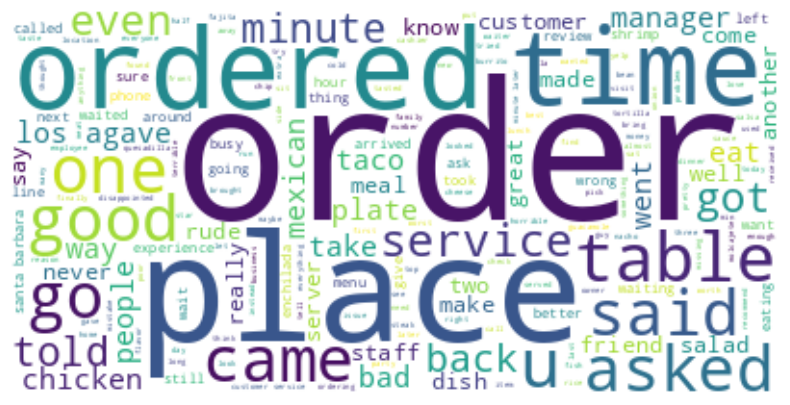

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Assuming LA_star1_reviews_df.processed_text contains your preprocessed text
text = " ".join(review for review in LA_star1_reviews_df.processed_text)

# Define additional stopwords
additional_stopwords = {'food', 'restaurant'}

# Combine default stopwords with your additional stopwords
stopwords = set(STOPWORDS).union(additional_stopwords)

# Generate a word cloud image, excluding the additional stopwords
wordcloud = WordCloud(background_color='white', stopwords=stopwords).generate(text)

# Display the generated word cloud:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis grid
plt.show()


In [ ]:
# Concatenate all text from the 'text_column' into a single string
text = " ".join(review for review in star1_reviews_df.processed_text)

# Generate a word cloud image
wordcloud = WordCloud(background_color='white').generate(text)

# Display the generated word cloud:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis grid
plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


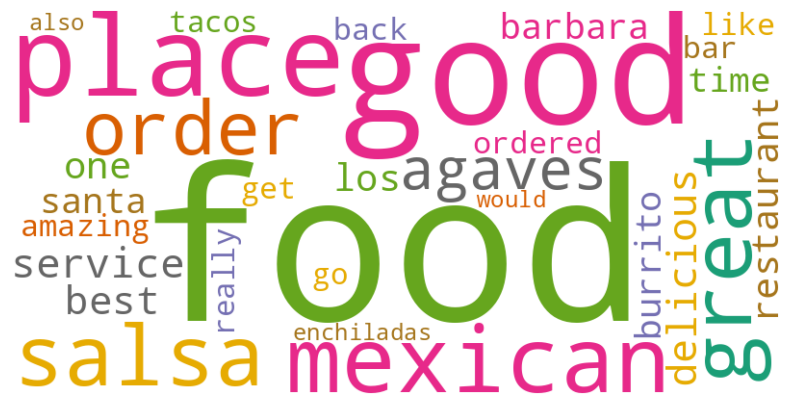

In [ ]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Make sure to download stopwords from NLTK
import nltk
nltk.download('punkt')
nltk.download('stopwords')

def create_word_cloud(train):
    # Tokenize and remove stopwords
    words = []
    for text in train['text']:
        words.extend(word_tokenize(text.lower()))  # Convert text to lowercase and tokenize

    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.isalpha() and word not in stop_words]  # Remove non-alphabetic words and stopwords

    # Count words and keep the top 30
    word_counts = Counter(filtered_words)
    most_common_words = word_counts.most_common(30)

    # Create a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=30, colormap='Dark2').generate_from_frequencies(dict(most_common_words))

    # Display the generated word cloud:
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis grid
    plt.show()

# Filter reviews for a specific business_id
filtered_reviews = reviews_df[reviews_df['name_x'] == "Los Agaves"]
create_word_cloud(filtered_reviews)

In [ ]:
print(pd.__version__)

1.5.3


In [ ]:
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

reviews_df.loc[:, 'sentiment'] = reviews_df['processed_lemma_text'].apply(lambda text: TextBlob(text).sentiment.polarity)

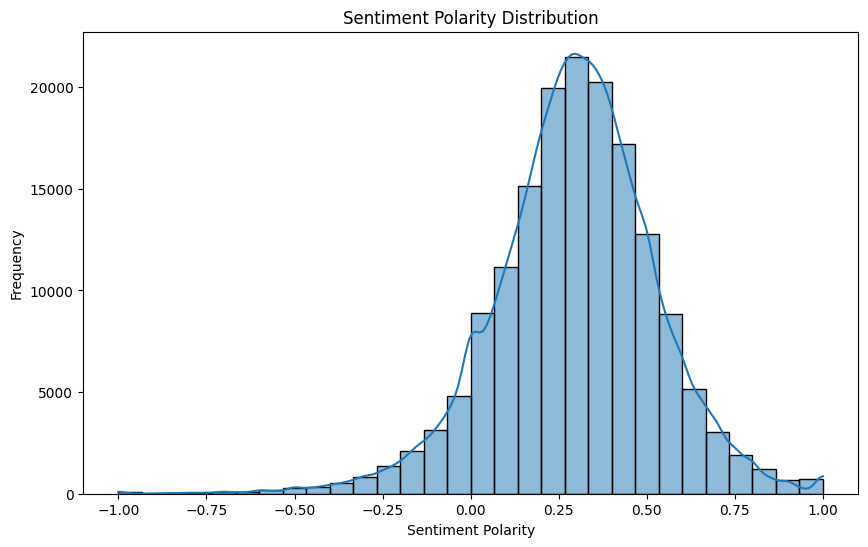

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(reviews_df['sentiment'], bins=30, kde=True)
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

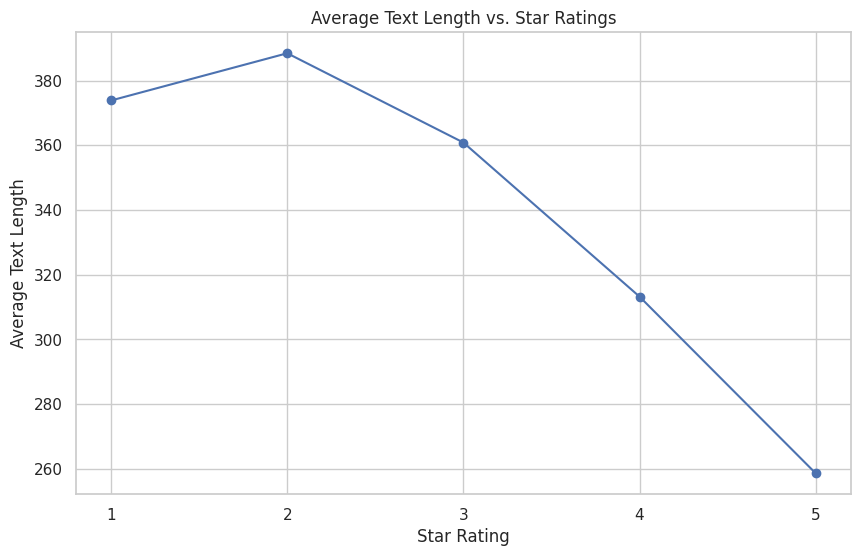

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming your df has 'text' and 'stars' columns
# For demonstration, let's create a sample DataFrame
# np.random.seed(42)
# sample_texts = ["This is a review." * np.random.randint(1, 10) for _ in range(100)]
# sample_stars = np.random.choice([1, 2, 3, 4, 5], size=100)

# df = pd.DataFrame({'text': sample_texts, 'stars': sample_stars})

# Step 1: Calculate text length
reviews_df['text_length'] = reviews_df['processed_lemma_text'].apply(len)

# Step 2: Calculate the average text length for each star rating
grouped = reviews_df.groupby('stars_y')['text_length'].mean().reset_index()

# Step 3: Plotting
plt.figure(figsize=(10, 6))
plt.plot(grouped['stars_y'], grouped['text_length'], marker='o', linestyle='-', color='b')
plt.title('Average Text Length vs. Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Average Text Length')
plt.grid(True)
plt.xticks([1, 2, 3, 4, 5]) # Assuming star ratings are discrete values from 1 to 5
plt.show()
